# Problem Statement



***Context and Importance:***

The wine industry is a multi-billion dollar global market, where both connoisseurs and casual drinkers rely heavily on wine reviews to make informed purchasing decisions. These reviews often encompass various aspects such as the wine's country of origin, variety, price, and tasting notes. Understanding the patterns and factors that influence wine ratings and prices can provide valuable insights for producers, retailers, and consumers alike.

***Objective:***

This analysis aims to explore and analyze a dataset of wine reviews to uncover key patterns and trends. Specifically, the objectives are to:

Identify the main factors influencing wine ratings and prices.
Examine the differences in wine characteristics across different countries and varieties.
Predict wine ratings based on available features using regression models.

***Research Questions:***

What are the primary factors that affect the price of wine?
Is there a significant difference in the average price of red wines compared to white wines?
How do wine ratings differ across different countries and varieties?

***Scope:***

The analysis will include data cleaning and preprocessing steps to prepare the dataset for in-depth analysis. It will employ descriptive statistics, visualizations, hypothesis testing, confidence intervals, and regression analysis to address the research questions. The focus will be on the dataset available from Kaggle, which includes detailed wine reviews.

In [89]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import t
import plotly.express as px
import statsmodels.api as sm

---

# Description of the dataset

**Source of dataset:** https://www.kaggle.com/datasets/zynicide/wine-reviews

**Number of observations**: The dataset contains 130,000 wine reviews.

**Number of variables per observation**: Each observation includes 14 variables.



In [90]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
110490,110490,Italy,"Aromas of dark berry, wild flower, Mediterrane...",Feudo Rosso,93,58.0,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Girolamo Russo 2012 Feudo Rosso (Etna),Red Blend,Girolamo Russo
22148,22148,France,Riesling has an ability to unite opposites: ri...,Les Princes Abbés,91,18.0,Alsace,Alsace,NaN,Anne Krebiehl MW,@AnneInVino,Domaines Schlumberger 2014 Les Princes Abbés R...,Riesling,Domaines Schlumberger
54836,54836,Spain,"Quite sweet on the nose, with cherry-cola, ber...",Brut Rosat,85,17.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,Gran Rigau NV Brut Rosat Sparkling (Cava),Sparkling Blend,Gran Rigau
126168,126168,US,Though it's been held back since being bottled...,NaN,88,25.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Tranche 2010 Barbera (Columbia Valley (WA)),Barbera,Tranche
20903,20903,US,"Light and supple, this Pinot is meant for drin...",NaN,87,28.0,California,Sonoma Coast,Sonoma,NaN,NaN,MacMurray Ranch 2006 Pinot Noir (Sonoma Coast),Pinot Noir,MacMurray Ranch


**Meaning and type of the different variables**

In [91]:
df.dtypes

Unnamed: 0                 int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

### Original Used Columns

| Column          | Description                                                            | Data Type       |
|-----------------|------------------------------------------------------------------------|-----------------|
| country         | The country where the wine is produced.                                | Object (String) |
| description     | A textual description of the wine's characteristics.                   | Object (String) |
| designation     | The name of the wine given by the winery.                              | Object (String) |
| points          | The wine rating on a scale from 0 to 100.                              | Integer         |
| price           | The price of the wine bottle in dollars.                               | Float           |
| province        | The province or state where the wine is produced.                      | Object (String) |
| region_1        | The primary wine region where the wine is produced.                    | Object (String) |
| region_2        | The secondary wine region where the wine is produced.                  | Object (String) |
| title           | The full name of the wine, including the vintage and other identifying information. | Object (String) |
| variety         | The type of grape used to produce the wine (e.g., Pinot Noir, Chardonnay). | Object (String) |
| winery          | The name of the winery that produced the wine.                         | Object (String) |

### Created Column

| Column          | Description            | Data Type |
|-----------------|------------------------------------------------------------------------|-----------------|
| is_outlier      | Wine outside lower and upper bounds                                    | bool            |
| price_category  | We have defined five different price category                          | category        |
| vintage         | The year of production                                                 | Integer         |
| review_length   | The lenght of the review                                               | Integer         |
| wine_type       | Red or With wine                                                       | Object (String) |


### Dropped Columns

| Column                 | Description                                                          | Data Type       |
|------------------------|----------------------------------------------------------------------|-----------------|
| Unnamed: 0             | An index column, possibly used to maintain the original order of the data. | Integer         |
| taster_name            | The name of the person who tasted and reviewed the wine.              | Object (String) |
| taster_twitter_handle  | The Twitter handle of the taster.                                     | Object (String) |


---

# Data Cleaning

The column ‘Unnamed: 0’ is not needed as it is the line number and we already have that.

We find that the columns ‘taster_name’ and ‘taster_twitter_handle’ are also not useful for our project.

We proceed to delete these columns from the dataframe:

In [92]:
df.drop(columns=['Unnamed: 0', 'taster_name', 'taster_twitter_handle'], inplace=True)

### Drop duplicates

as first we check for duplicates and delete them

In [93]:
duplicated = df.duplicated().sum()
print(f"Total duplicate: {duplicated}")
df.drop_duplicates(inplace=True)
duplicated = df.duplicated().sum()
print(f"Total duplicate: {duplicated}")

Total duplicate: 9983
Total duplicate: 0


### Data Quality Assessment

Display of missing values, unique values and duplicates of each column

In [94]:
# Initialize a list to store the data
data_quality = []

# Calculate the metrics for each column and store them in the list
for column in df.columns:
    nan_count = df[column].isna().sum()
    unique_count = df[column].nunique()
    total_entries = df.shape[0]
    duplicates = total_entries - unique_count - nan_count
    
    data_quality.append({
        'Column': column,
        'Missing Values': nan_count,
        'Unique Values': unique_count,
        'Duplicates': duplicates
    })

# Create a DataFrame from the list
data_quality_df = pd.DataFrame(data_quality)

data_quality_df

,Column,Missing Values,Unique Values,Duplicates
0,country,59,43,119886
1,description,0,119955,33
2,designation,34545,37979,47464
3,points,0,21,119967
4,price,8395,390,111203
5,province,59,425,119504
6,region_1,19560,1229,99199
7,region_2,73219,17,46752
8,title,0,118840,1148
9,variety,1,707,119280


the columns that need to be arranged are ‘country’, ‘designation’, ‘price’, ‘province’, 'region_1', “region_2” and “variety”.

I also have to check ‘description’ as it should be unique for each wine

### Country column analysis

Filtering the DataFrame to show only rows where 'country' has NaN values

In [95]:
# Filter the DataFrame to show only rows where 'country' has NaN values
rows_with_nan = df[df['country'].isna()]
rows_with_nan.head(10)

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
913,NaN,"Amber in color, this wine has aromas of peach ...",Asureti Valley,87,30.0,NaN,NaN,NaN,Gotsa Family Wines 2014 Asureti Valley Chinuri,Chinuri,Gotsa Family Wines
3131,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,NaN,Barton & Guestier NV Partager Red,Red Blend,Barton & Guestier
4243,NaN,"Violet-red in color, this semisweet wine has a...",Red Naturally Semi-Sweet,88,18.0,NaN,NaN,NaN,Kakhetia Traditional Winemaking 2012 Red Natur...,Ojaleshi,Kakhetia Traditional Winemaking
9509,NaN,This mouthwatering blend starts with a nose of...,Theopetra Malagouzia-Assyrtiko,92,28.0,NaN,NaN,NaN,Tsililis 2015 Theopetra Malagouzia-Assyrtiko W...,White Blend,Tsililis
9750,NaN,This orange-style wine has a cloudy yellow-gol...,Orange Nikolaevo Vineyard,89,28.0,NaN,NaN,NaN,Ross-idi 2015 Orange Nikolaevo Vineyard Chardo...,Chardonnay,Ross-idi
11150,NaN,"A blend of 85% Melnik, 10% Grenache Noir and 5...",NaN,89,20.0,NaN,NaN,NaN,Orbelus 2013 Melnik,Melnik,Orbelus
11348,NaN,"Light and fruity, this is a wine that has some...",Partager,82,NaN,NaN,NaN,NaN,Barton & Guestier NV Partager White,White Blend,Barton & Guestier
14030,NaN,"This Furmint, grown in marl soils, has aromas ...",Márga,88,25.0,NaN,NaN,NaN,St. Donat 2013 Márga White,White Blend,St. Donat
16000,NaN,"Jumpy, jammy aromas of foxy black fruits are s...",Valle de los Manantiales Vineyard,86,40.0,NaN,NaN,NaN,Familia Deicas 2015 Valle de los Manantiales V...,Tannat,Familia Deicas
16749,NaN,Winemaker: Bartho Eksteen. This wooded Sauvy s...,Cape Winemakers Guild Vloekskoot Wooded,91,NaN,NaN,NaN,NaN,Bartho Eksteen 2016 Cape Winemakers Guild Vloe...,Sauvignon Blanc,Bartho Eksteen


59 lines are missing the country, province and region, so we have no idea where the wine comes from.

As these are 59 lines out of 111538, we decide to delete them.

In [96]:
df = df.dropna(subset=["country"])

### Description column analysis

Above we can see that the column "description" has 33 duplicate, a description is something unique, we must investigate

now i will display some duplicate wine to understand better

In [97]:
# Check for duplicates in the 'description' column
duplicate_descriptions = df[df.duplicated(subset='description', keep=False)]

# Display the duplicate 
#duplicate_descriptions_full = duplicate_descriptions
#duplicate_descriptions_full

duplicate_example = duplicate_descriptions[duplicate_descriptions['description'] == duplicate_descriptions.iloc[0]['description']]
duplicate_example_full = duplicate_example.head(5)

duplicate_example_full

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
2159,Italy,"Easygoing and enjoyable, this has aromas of ma...",NaN,84,15.0,Central Italy,Montepulciano d'Abruzzo,NaN,Valori 2014 Montepulciano d'Abruzzo,Montepulciano,Valori
22963,Italy,"Easygoing and enjoyable, this has aromas of ma...",NaN,86,NaN,Central Italy,Montepulciano d'Abruzzo,NaN,Quattro Mani 2015 Montepulciano d'Abruzzo,Montepulciano,Quattro Mani


in this case we can see that all columns have the same values.

we show several rows to see if this is the case for all duplicates

In [98]:
sorted_duplicates = duplicate_descriptions.sort_values(by='description')
sorted_duplicates

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
71853,France,90–92. Barrel sample. This is a solid and dens...,Barrel Sample,91,NaN,Bordeaux,Moulis-en-Médoc,NaN,Château Maucaillou 2012 Barrel Sample (Moulis...,Bordeaux-style Red Blend,Château Maucaillou
71851,France,90–92. Barrel sample. This is a solid and dens...,Barrel Sample,91,NaN,Bordeaux,Margaux,NaN,Château Pontac-Lynch 2012 Barrel Sample (Marg...,Bordeaux-style Red Blend,Château Pontac-Lynch
105559,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,93,NaN,Bordeaux,Saint-Julien,NaN,Château Gruaud Larose 2012 Barrel Sample (Sai...,Bordeaux-style Red Blend,Château Gruaud Larose
105554,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,93,NaN,Bordeaux,Pauillac,NaN,Château Grand-Puy-Lacoste 2012 Barrel Sample ...,Bordeaux-style Red Blend,Château Grand-Puy-Lacoste
73905,Italy,"Almost too much of a good thing, Passo is a th...",Passo,88,35.0,Veneto,Rosso del Veronese,NaN,Stefano Accordini 2007 Passo Red (Rosso del Ve...,Red Blend,Stefano Accordini
...,...,...,...,...,...,...,...,...,...,...,...
19269,Italy,This zesty red has pretty aromas that suggest ...,NaN,87,30.0,Tuscany,Rosso di Montalcino,NaN,Carpineto 2014 Rosso di Montalcino,Sangiovese,Carpineto
83693,US,Very ripe and forward in baked fruit or pie-fi...,NaN,84,45.0,California,Santa Ynez Valley,Central Coast,Sunstone 2006 Syrah (Santa Ynez Valley),Syrah,Sunstone
61484,US,Very ripe and forward in baked fruit or pie-fi...,Reserve,85,48.0,California,Santa Ynez Valley,Central Coast,Sunstone 2006 Reserve Syrah (Santa Ynez Valley),Syrah,Sunstone
31584,Italy,"Vibrant and spicy, this savory red delivers ar...",Costera,90,18.0,Sicily & Sardinia,Cannonau di Sardegna,NaN,Argiolas 2013 Costera (Cannonau di Sardegna),Red Blend,Argiolas


You can see that in these wines, although the description is the same, there are columns with different values, so they are not duplicates

### Handle NaN

***Columns with string data type***

We want to replace NaN value with 0 in the Price column

In [99]:
rows_with_nan = df[df['variety'].isna()]
rows_with_nan

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
86909,Chile,"A chalky, dusty mouthfeel nicely balances this...",NaN,88,17.0,Maipo Valley,NaN,NaN,Carmen 1999 (Maipo Valley),NaN,Carmen


In [100]:

df['variety'].fillna('Not-Available', inplace=True)

In [101]:
# Define the columns you want to check and replace NaN values
columns_to_check = ['designation', 'province', 'region_1', 'region_2', 'variety']

# Iterate over each column and replace NaN values with 'Not-available'
for column in columns_to_check:
    # Find the index of the row with NaN in the current column
    row_with_nan_index = df[df[column].isna()].index

    # Assign 'Not-available' to that row and column
    df.loc[row_with_nan_index, column] = 'Not-available'

***Price column***


It makes no sense to replace NaN in the price with 0, because in most statistics we would discard these rows. So we decide to delete these 8391 rows

In [102]:
nan_count = df['price'].isna().sum()
print("Before:")
print(f"total NaN in price: {nan_count}")

#df['price'] = df['price'].fillna(0).astype('float64')
df = df.dropna(subset=['price'])

nan_count = df['price'].isna().sum()
print("After:")
print(f"total NaN in price: {nan_count}")

Before:
total NaN in price: 8391
After:
total NaN in price: 0


### Level of noise in price

In this section, we aim to identify the level of noise within our dataset by detecting outliers in the price column. Outliers are extreme values that deviate significantly from the rest of the data and can potentially skew the analysis. By flagging these outliers, we can better understand the variability and quality of our data.

We can have noises in 'points' and 'price' columns:

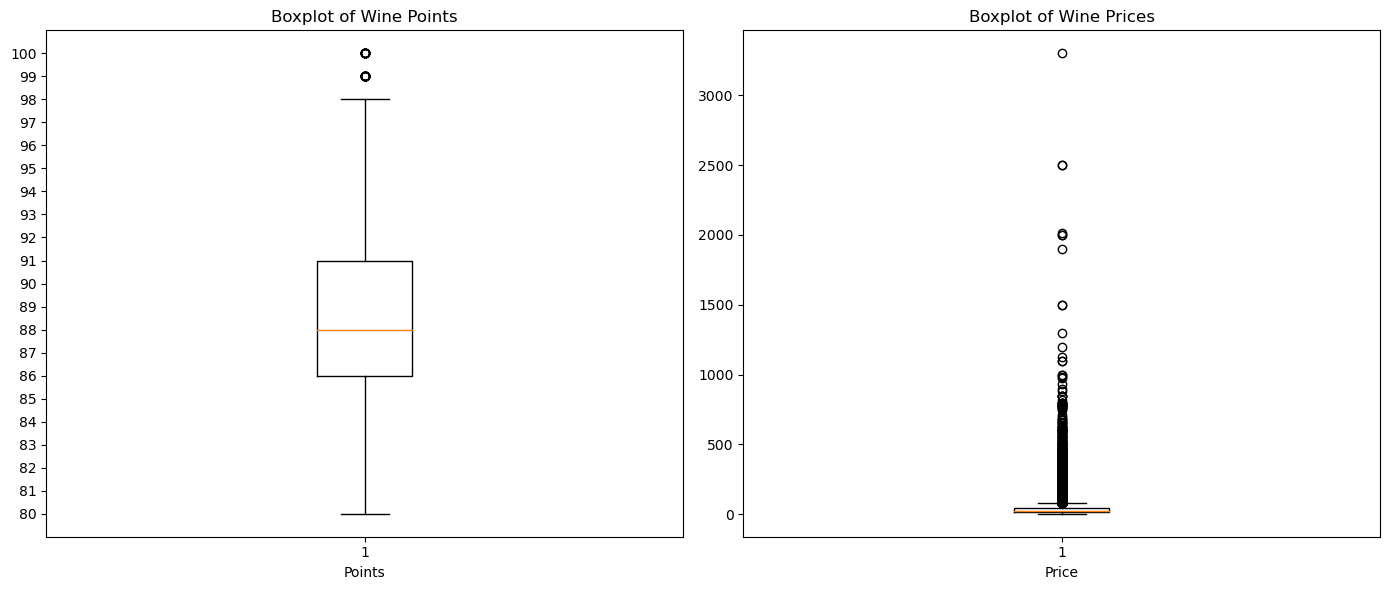

In [103]:
# Create boxplots for 'points' and 'price'
plt.figure(figsize=(14, 6))

# Boxplot for 'points'
plt.subplot(1, 2, 1)
plt.boxplot(df['points'])
plt.title('Boxplot of Wine Points')
plt.xlabel('Points')
plt.yticks(np.arange(80, 101, 1))

# Boxplot for 'price'
plt.subplot(1, 2, 2)
plt.boxplot(df['price'])
plt.title('Boxplot of Wine Prices')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

From the boxplot of the points, we can see that we only have two Vaudores as noise,

The price boxplot doesn't tell us much in this visualisation, so let's plot it horizontally.

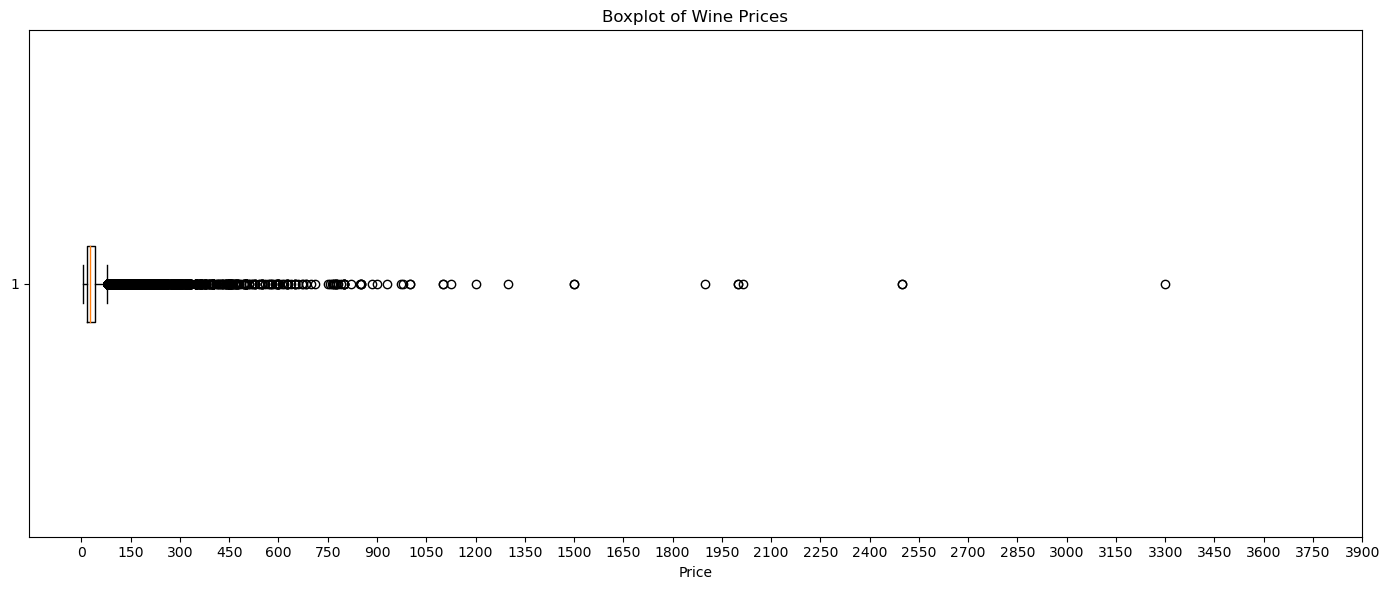

In [104]:
# Create boxplots for 'points' and 'price'
plt.figure(figsize=(14, 6))

# Boxplot for 'price'
#plt.subplot(1, 2, 2)
plt.boxplot(df['price'], vert=False)
plt.title('Boxplot of Wine Prices')
plt.xlabel('Price')
plt.xticks(np.arange(0, 4000, 150))

plt.tight_layout()
plt.show()

In [105]:
# Using IQR to identify outliers in the 'price' column
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flagging the outliers without removing them
df['is_outlier'] = (df['price'] < lower_bound) | (df['price'] > upper_bound)
outliers_df = df[df['is_outlier'] == True]

num_outliers = df['is_outlier'].sum()
total_observations = df.shape[0]

# Proportion of outliers
proportion_outliers = num_outliers / total_observations

print(f"Number of outlier wines: {num_outliers}")
print(f"Total number of observations: {total_observations}")
print(f"Proportion of outliers: {proportion_outliers:.2%}")



Number of outlier wines: 6869
Total number of observations: 111538
Proportion of outliers: 6.16%


### Outliners management

We decided to keep the outliners with a price below $1000 as they represent about 6% of the dataset. The 11 outliners above $1000 are eliminated as they have data that is too different from the rest of the dataset.

In [106]:
df = df[df['price'] <= 1000]

---

# Preprocessing

with this dataset is interesting create new columns, like price category, wine vintage and lenght of description.

## Price Category column


we want to create some price category:

At first we plot the histogram of the price to have an idea of the distribution:

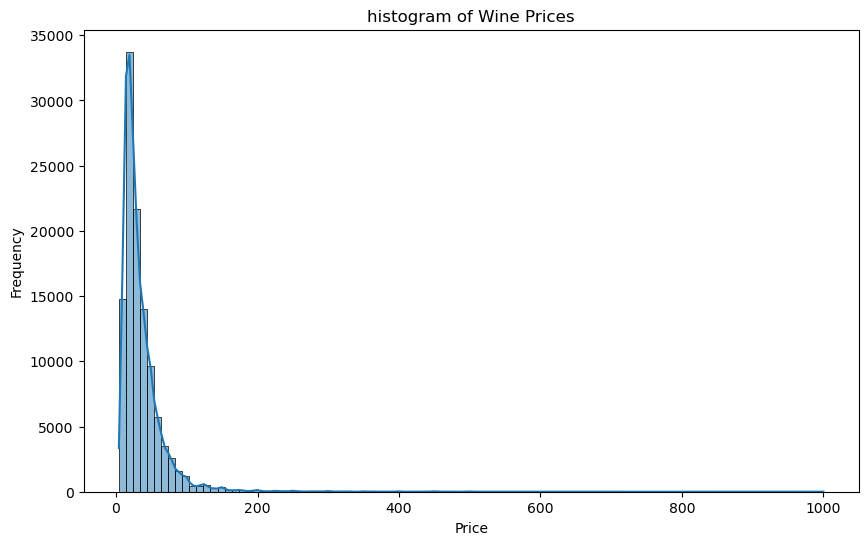

In [107]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=100, kde=True)
plt.title('histogram of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

As we can see, the plot of price is right-skewed, and we could also observe this by categorising the wines into a price category.

To analyse the distribution of wines in different price ranges, we categorise prices into 'Low', 'Medium', 'High', 'Very High', 'Premium'.

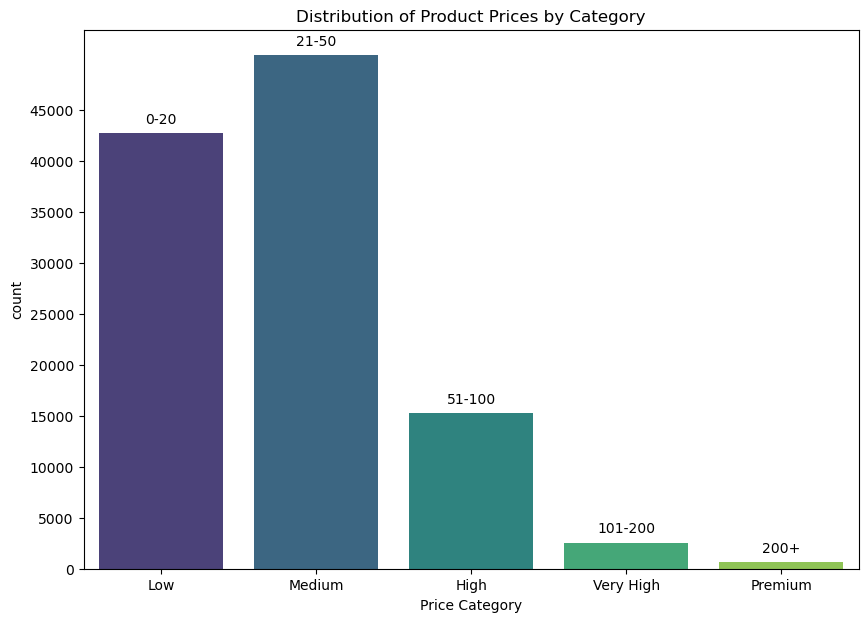

In [108]:
bins = [0, 20, 50, 100, 200, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High', 'Premium']
df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels)

# Plotting with seaborn
plt.figure(figsize=(10, 7))
palette = sns.color_palette("viridis", len(labels)) # Create a palette with a color for each category
ax = sns.countplot(data=df, x='price_category', palette=palette)
plt.title('Distribution of Product Prices by Category')
plt.xlabel('Price Category')
plt.ylabel('count')
plt.yticks(np.arange(0, 50000, 5000))

# Annotate bars with price range
price_ranges = ['0-20', '21-50', '51-100', '101-200', '200+']
for p, label, price_range in zip(ax.patches, labels, price_ranges):
    ax.annotate(f'{price_range}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

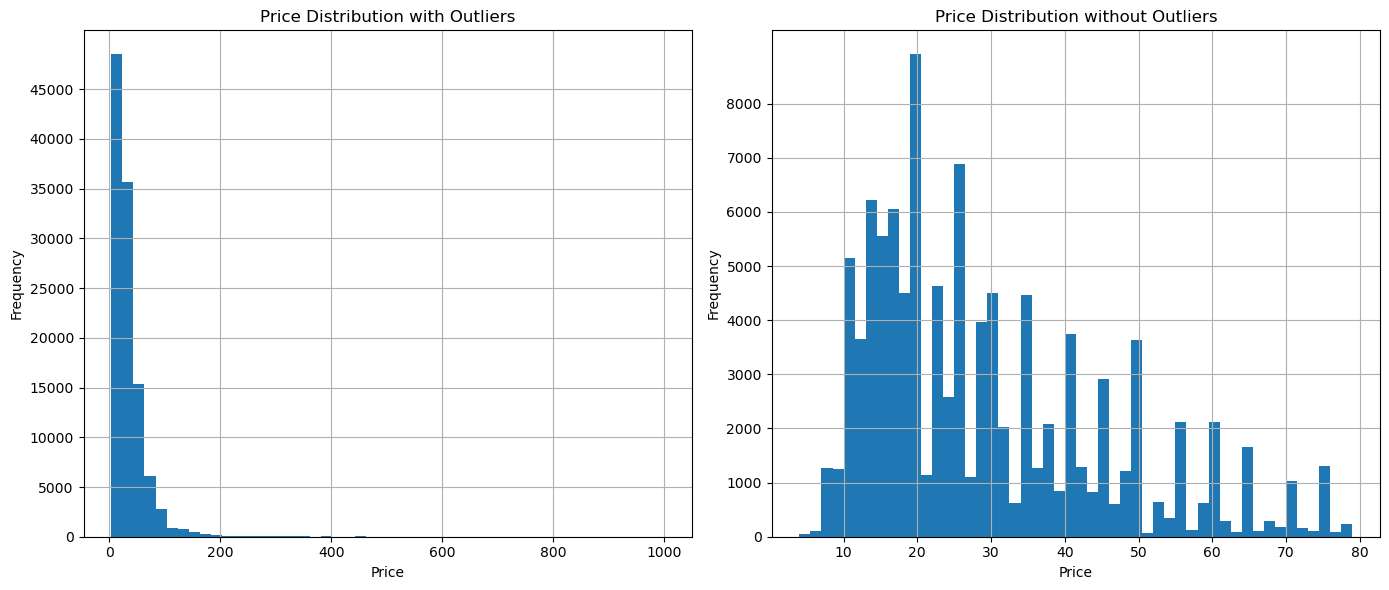

In [109]:
# Create a boolean mask for non-outliers
non_outliers_mask = df['is_outlier'] == False
df_without_outliers = df[non_outliers_mask]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df['price'].hist(bins=50)
plt.title('Price Distribution with Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 50000, 5000))

# Histogram of prices without outliers
plt.subplot(1, 2, 2)
df_without_outliers['price'].hist(bins=50)
plt.title('Price Distribution without Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 9000, 1000))

plt.tight_layout()
plt.show()

## Wine Vintage column

since the ‘description’ and ‘title’ columns contain the vintage of the wine, it is interesting to create a 'vintage' column to do some analysis

In [110]:
import re
# Function to extract the vintage year from the title or description
def extract_vintage(row):
    # Try to find the year in the title first
    title_match = re.search(r'\b(19|20)\d{2}\b', row['title'])
    if title_match:
        return int(title_match.group(0))
    # If not found in title, try to find the year in the description02
    description_match = re.search(r'\b(19|20)\d{2}\b', row['description'])
    if description_match:
        return int(description_match.group(0))
    # If not found in either, return None
    return None

# Apply the function to the dataframe to create the vintage column
df['vintage'] = df.apply(extract_vintage, axis=1)

# Check that the column has no Nan value
nan_counts = df.isna().sum()
nan_counts
print("Number of NaN: ", nan_count)

# Converting the vintage column to integer type to remove the .0
df['vintage'] = df['vintage'].astype('Int64')

#new column show
df[['title', 'description', 'vintage']].head()


Number of NaN:  0


,title,description,vintage
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",2011
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",2013
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",2013
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",2012
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Blackberry and raspberry aromas show a typical...,2011


## Description length column

The length of the wine description might correlate with the wine rating, so we create a new variable to capture this information.

In [111]:
def calculate_review_length(description):
    if pd.notnull(description):
        return len(description)
    else:
        return 0

df['review_length'] = df['description'].apply(calculate_review_length)

#new column show
df[['description', 'review_length']].head()

,description,review_length
1,"This is ripe and fruity, a wine that is smooth...",227
2,"Tart and snappy, the flavors of lime flesh and...",186
3,"Pineapple rind, lemon pith and orange blossom ...",199
4,"Much like the regular bottling from 2012, this...",249
5,Blackberry and raspberry aromas show a typical...,261


# Data Exploration

## Histogram of Wine Points

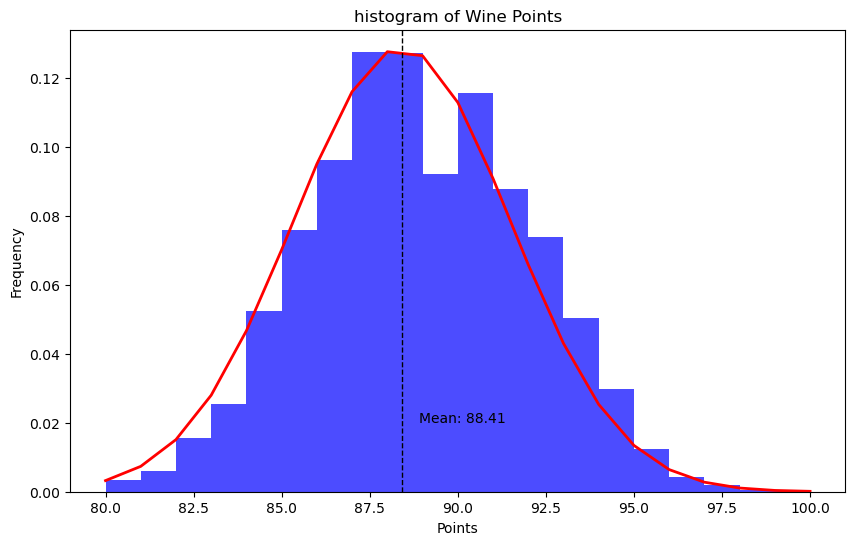

In [112]:
# 'points' is our column of interest
mean_points = df['points'].mean()
std_points = df['points'].std()

# Generate values for the normal distribution curve
normal_dist = stats.norm.pdf(sorted(df['points']), mean_points, std_points)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['points'], bins=20, density=True, color='blue', alpha=0.7)
plt.plot(sorted(df['points']), normal_dist, color='red', linewidth=2)
plt.title('histogram of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.axvline(mean_points, color='k', linestyle='dashed', linewidth=1)
plt.text(mean_points + 0.5, 0.02, f'Mean: {mean_points:.2f}', rotation=0)
plt.show()

This histogram shows the distribution of wine scores with a normal distribution curve. The distribution appears to be approximately normal, with most wine scores centred around the mean and slightly skewed to the right. This visualisation shows that most wines score between 85 and 92 points.

## Review Lenght Distribution

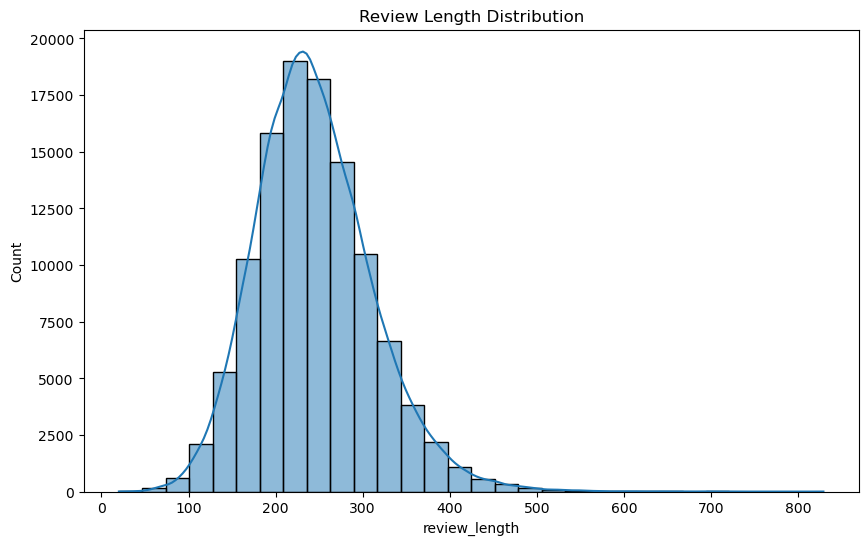

In [113]:
# Plot the hisogram
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Review Length Distribution')
plt.show()

This histogram shows the distribution of the length of wine reviews, measured in characters or words. The distribution is roughly normal, with a peak around 250 characters/words.  The fitted line suggests that reviews are generally of moderate length, with fewer extremely short or long reviews.

## Animated World Wine Distribution Map

In [114]:
# Count the number of wines per country and vintage year
country_vintage_counts = df.groupby(['country', 'vintage']).size().reset_index(name='count')

# Sort the DataFrame by 'vintage' and 'country'
country_vintage_counts = country_vintage_counts.sort_values(by=['vintage', 'country'])

# Calculate the cumulative count of wines for each country
country_vintage_counts['cumulative_count'] = country_vintage_counts.groupby('country')['count'].cumsum()

# Create a complete range of years for each country
all_years = pd.DataFrame({'vintage': range(country_vintage_counts['vintage'].min(), country_vintage_counts['vintage'].max() + 1)})
country_list = country_vintage_counts['country'].unique()

# Merge the original data with the complete range of years
full_data = pd.DataFrame()
for country in country_list:
    country_data = country_vintage_counts[country_vintage_counts['country'] == country]
    country_data = all_years.merge(country_data, on='vintage', how='left')
    country_data['country'] = country
    country_data['cumulative_count'] = country_data['cumulative_count'].fillna(method='ffill').fillna(0)
    full_data = pd.concat([full_data, country_data], ignore_index=True)

# Generate the animated world map with cumulative wine counts
fig = px.choropleth(full_data,
                    locations="country",
                    locationmode='country names',
                    color="cumulative_count",
                    hover_name="country",
                    animation_frame="vintage",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="World Wine Distribution Over Time (Cumulative)")
fig.update_layout(width=1400, height=700)
fig.show()


This chart helps us understand how vintages are distributed in our dataset. The colour gradient from yellow to purple shows the cumulative number of reviews, with yellow representing the highest number of reviews. The wines reviewed are mainly from the United States, France and Italy.

it is interesting to note that before 1984 we have no American wines

## US wine distribution per state

In [115]:
# Filter the DataFrame to include only rows where the country is 'US'
us_wine_data = df[df['country'] == 'US']

# Filter the DataFrame to include only rows where the country is 'US' (repeated, this can be removed as it is redundant)
us_wine_data = df[df['country'] == 'US']

# Count the number of wines per state (province)
state_wine_counts = us_wine_data['province'].value_counts().reset_index()
state_wine_counts.columns = ['province', 'count']

# Correct list of US state abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Convert state names to abbreviations
state_wine_counts['province'] = state_wine_counts['province'].map(state_abbreviations)

# Remove any NaN values that may have been introduced
state_wine_counts = state_wine_counts.dropna()

# Generate the map
fig = px.choropleth(state_wine_counts,
                    locations="province",
                    locationmode='USA-states',
                    scope="usa",
                    color="count",
                    hover_name="province",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Wine distribution in the US")
fig.update_layout(width=1200, height=600)
fig.show()


Much of Central and North America has no wine, which makes sense as these states do not have a favourable climate for growing grapes.

California, Washington and Oregon are prominently highlighted, indicating that these states have the highest number of wine reviews, reflecting their significant wine production.

## Vintage Distribution Treemap

In [116]:
# Calculate the counts of each vintage year and reset the index to make it a DataFrame
vintage_counts = df['vintage'].value_counts().reset_index()
vintage_counts.columns = ['vintage', 'count']

# Create the treemap
fig = px.treemap(vintage_counts, path=['vintage'], values='count',
                 color='count', color_continuous_scale='Viridis')

# Update the layout of the treemap
fig.update_layout(
    title='Vintage Distribution Treemap',
    title_font_size=24,
    autosize=False,
    width=800,
    height=600
)

# Show the treemap
fig.show()

The treemap shows that more recent vintages (2012-2014) have the highest number of reviews. This trend could suggest several things: newer vintages are more accessible and therefore more reviewed, or it could reflect a growing interest in contemporary wines. It also suggests that older vintages are either less accessible or less frequently reviewed, possibly due to their scarcity or the higher prices they command, which limits the number of people who review them.

## Bubble Chart of Top 50 Variety

In [117]:
# Select the columns 'variety', 'points', and 'price' for the bubble chart data and create a copy
bubble_data = df[['variety', 'points', 'price']].copy()

# Drop rows with missing values in 'variety', 'points', and 'price' columns
bubble_data.dropna(subset=['variety', 'points', 'price'], inplace=True)

# Get the top 10 varieties by frequency
top_varieties = bubble_data['variety'].value_counts().head(10).index

# Filter the dataset for the top varieties
top_varieties_data = bubble_data[bubble_data['variety'].isin(top_varieties)]

# Group by variety and calculate average points and price for each variety
top_grouped_data = top_varieties_data.groupby('variety').agg({'points': 'mean', 'price': 'mean'}).reset_index()

# Get the frequency of each variety
variety_counts = bubble_data['variety'].value_counts()

# Add the frequency count to the grouped data
top_grouped_data['count'] = top_grouped_data['variety'].map(variety_counts)

# Create the bubble chart using Plotly
fig = px.scatter(top_grouped_data, x='points', y='price', size='count', color='count',
                 hover_name='variety', hover_data={'count': True},
                 size_max=60, title='Bubble Chart of Top 50 Wine Varieties',
                 labels={'points': 'Average Points', 'price': 'Average Price'},
                 color_continuous_scale=px.colors.sequential.Viridis)

# Customize the hover template to show count and avoid overlapping text
fig.update_traces(marker=dict(opacity=0.8, line=dict(width=2, color='DarkSlateGrey')),
                  hovertemplate='<b>%{hovertext}</b><br>Count: %{customdata[0]}<br>Points: %{x}<br>Price: %{y}')

# Adjust layout for better readability
fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
    margin=dict(l=40, r=40, b=40, t=40),
    title_font_size=24
)

# Show the interactive plot
fig.show()


The bubble chart shows that there is a positive correlation between wine price and points, although it is not perfectly linear. Higher scoring wines tend to be more expensive, which is to be expected. However, there are some varieties that achieve high scores without commanding exorbitant prices, highlighting potential value wines for consumers looking for quality without overspending. The graph also shows which varieties are most reviewed, with larger bubbles indicating a higher number of reviews, possibly reflecting popularity or wider availability.

## Average Wine Rating Map

In [118]:
# Calculate the average rating (points) for each country and reset the index to make it a DataFrame
country_rating_avg = df.groupby('country')['points'].mean().reset_index()
country_rating_avg.columns = ['country', 'average_rating']

# Generate the world map for the average ratings
fig = px.choropleth(country_rating_avg,
                    locations="country",
                    locationmode='country names',
                    color="average_rating",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Average Wine Rating by Country")

# Update the layout of the map
fig.update_layout(width=1400, height=700)  # Set the dimensions of the map

# Show the interactive map
fig.show()

Europe and North America have good scores, it is strange to note that India has one of the best scores, most likely this average is given by a very small sample.

## Average Wine Price Map

In [119]:
# Calculate the average price for each country and reset the index to make it a DataFrame
country_price_avg = df.groupby('country')['price'].mean().reset_index()
country_price_avg.columns = ['country', 'average_price']

# Generate the world map for the average prices
fig = px.choropleth(country_price_avg,
                    locations="country",
                    locationmode='country names',
                    color="average_price",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Average Wine Price by Country")

# Update the layout of the map
fig.update_layout(width=1400, height=700) 

# Show the interactive map
fig.show()

As expected, switzerland has the highest average price, trailing central europe and the united states

Looking at the two maps, we can see that the price of wine often corresponds to the quality (low price -> low quality). Except for India, which has one of the lowest prices and one of the highest ratings.

---

# Hypotesis testing

## state of three hypotesis testing:

**hypotesis 1**
- Null hypothesis (H0): There is no difference in average points between wines from Italy and France.

- Alternative hypothesis (H1): There is a difference in average points between wines from Italy and France.

**hypotesis 2**
- Null Hypothesis (H0): There is no correlation between the price of wine and its rating (points).
 
- Alternative Hypothesis (H1): There is a significant correlation between the price of wine and its rating (points).

**hypotesis 3**
- Null Hypothesis (H0): There is no difference in the average price of red wines and white wines.

- Alternative Hypothesis (H1): There is a significant difference in the average points of red wines compared to white wines.

## hypotesis 1

### Two-Sample t-Test
e want to test if there is a significant difference in the average ratings (points) between wines from Italy and France.

- Null Hypothesis ($H_0$): $\mu_{Italy} = \mu_{France}$ (There is no significant difference in the average ratings between Italian and French wines)
- Alternative Hypothesis ($H_1$): $\mu_{Italy} \neq \mu_{France}$ (There is a significant difference in the average ratings between Italian and French wines)

In [120]:
# Select 'points' column from the two country
italy_wines = df[df['country'] == 'Italy']['points']
france_wines = df[df['country'] == 'France']['points']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(italy_wines.dropna(), france_wines.dropna(), equal_var=False)

# Print the t-statistic and p-value from the t-test
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the average rating of wines from Italy and France.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the average rating of wines from Italy and France.")

t-statistic: -3.3819442145552445, p-value: 0.0007206195084522533
Reject the null hypothesis: There is a significant difference in the average rating of wines from Italy and France.


The negative t-statistic suggests that, on average, the ratings of Italian wines are lower than those of French wines. However, further investigation would be needed to understand the underlying reasons for this difference, such as differences in wine production, cultural preferences, or other factors.

## hypotesis 2

We want to categorize the wine varieties into red and white types and analyze their distributions to understand the composition of the dataset.
- Null Hypothesis ($H_0$): The distribution of wine ratings is the same for red and white wine varieties.
- Alternative Hypothesis ($H_1$): The distribution of wine ratings is different for red and white wine varieties.

This categorization helps in understanding the distribution of red and white wines in the dataset, allowing for further analysis and comparisons between these two categories.

We then go on to consider only a portion of our dataset, choosing the top white wines and the top red wines manually

In [122]:
# Get the count of each variety in the DataFrame
variety_counts = df['variety'].value_counts()

# Display the top 100 varieties by count
top_100_varieties = variety_counts.head(100)

# List of top red wine varieties
top_red_varieties = [
    'Pinot Noir', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 
    'Syrah', 'Merlot', 'Zinfandel', 'Malbec', 'Sangiovese', 'Nebbiolo', 
    'Portuguese Red', 'Tempranillo', 'Rhône-style Red Blend', 'Cabernet Franc', 
    'Shiraz', 'Gamay', 'Petite Sirah', 'Grenache', 'Tempranillo Blend', 
    'Barbera', 'Sangiovese Grosso', 'Carmenère', 'Aglianico', 'Nero d\'Avola', 
    'Petit Verdot', 'Corvina, Rondinella, Molinara', 'Cinsault', 
    'Touriga Nacional', 'Bonarda', 'Carignan',
    'Mencia', 'Mourvèdre', 'Primitivo', 'Teroldego'
]

# List of top white wine varieties
top_white_varieties = [
    'Chardonnay', 'Riesling', 'Sauvignon Blanc', 'Rosé', 'White Blend', 
    'Sparkling Blend', 'Pinot Gris', 'Champagne Blend', 'Grüner Veltliner', 
    'Pinot Grigio', 'Viognier', 'Portuguese White', 'Gewürztraminer', 
    'Bordeaux-style White Blend', 'Glera', 'Chenin Blanc', 'Albariño', 
    'Rhône-style White Blend', 'Pinot Blanc', 'Garnacha', 'Moscato', 
    'Sauvignon', 'Verdejo', 'Trebbiano', 'Verdicchio', 'Sylvaner', 'Pecorino',
    'Loureiro', 'Gros Manseng', 'Grenache Blanc', 'Assyrtiko', 
    'Müller-Thurgau', 'Trebbiano d’Abruzzo', 'Soave'
]

# Function to categorize wine types based on variety
def categorize_wine(variety):
    if variety in top_red_varieties:
        return 'Red'
    elif variety in top_white_varieties:
        return 'White'
    else:
        return 'Unknown'

# Apply the function to create a new column 'wine_type' in the DataFrame
df['wine_type'] = df['variety'].apply(categorize_wine)

# Filter the DataFrame to exclude rows where 'wine_type' is 'Unknown'
df = df[df['wine_type'] != 'Unknown']

***Red Wines***

In [123]:
# Identify outliers using IQR for red wines
# Filter the DataFrame to include only red wines
red_wines = df[df['wine_type'] == 'Red']

# Calculate the first quartile (25th percentile)
Q1_red = red_wines['price'].quantile(0.25)

# Calculate the third quartile (75th percentile)
Q3_red = red_wines['price'].quantile(0.75)

# Calculate the Interquartile Range (IQR) for red wine prices
IQR_red = Q3_red - Q1_red

# Calculate the boundaries
lower_bound_red = Q1_red - 1.5 * IQR_red
upper_bound_red = Q3_red + 1.5 * IQR_red

# Create a mask to identify non-outlier red wines within the IQR bounds
non_outliers_mask_red = (red_wines['price'] >= lower_bound_red) & (red_wines['price'] <= upper_bound_red)

# Filter the red wines DataFrame to exclude outliers
df_red_without_outliers = red_wines[non_outliers_mask_red]


***White Wines***

In [124]:
# Identify outliers using IQR for white wines
# Filter the DataFrame to include only white wines
white_wines = df[df['wine_type'] == 'White']

# Calculate the first quartile (25th percentile)
Q1_white = white_wines['price'].quantile(0.25)

# Calculate the third quartile (75th percentile)
Q3_white = white_wines['price'].quantile(0.75)

# Calculate the Interquartile Range (IQR) for white wine prices
IQR_white = Q3_white - Q1_white

# Calculate the boundaries
lower_bound_white = Q1_white - 1.5 * IQR_white
upper_bound_white = Q3_white + 1.5 * IQR_white

# Create a mask to identify non-outlier white wines within the IQR bounds
non_outliers_mask_white = (white_wines['price'] >= lower_bound_white) & (white_wines['price'] <= upper_bound_white)

# Filter the white wines DataFrame to exclude outliers
df_white_without_outliers = white_wines[non_outliers_mask_white]


###

To get a clearer idea, let's plot the graphs of the distribution of red wines and white wines without the outliers 

###

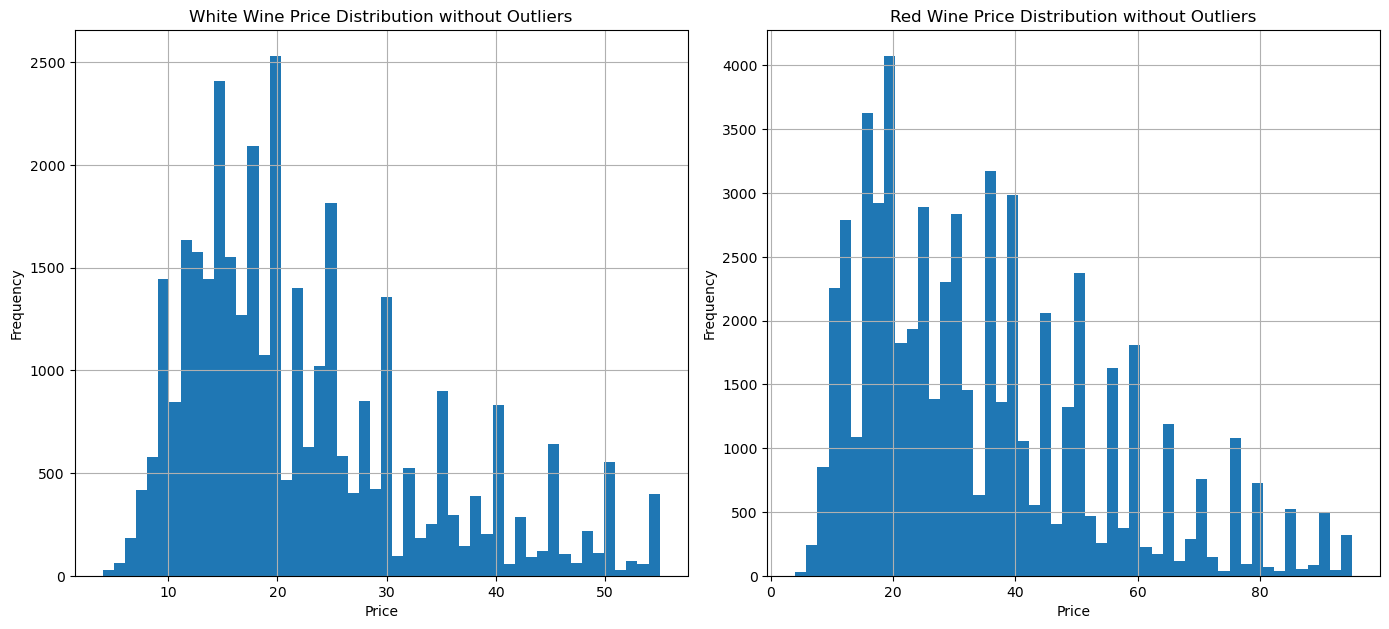

In [125]:
# Set the size of the overall figure
plt.figure(figsize=(14, 12))

# Histogram of prices without outliers for red wines
plt.subplot(2, 2, 2)  
df_red_without_outliers['price'].hist(bins=50) 
plt.title('Red Wine Price Distribution without Outliers')
plt.xlabel('Price') 
plt.ylabel('Frequency')

# Histogram of prices without outliers for white wines
plt.subplot(2, 2, 1)  
df_white_without_outliers['price'].hist(bins=50)  
plt.title('White Wine Price Distribution without Outliers')  
plt.xlabel('Price') 
plt.ylabel('Frequency')  

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the histograms
plt.show()

### 

In [126]:
# Select 'points' column for the two type (without outliers)
red_wine_ratings = df_red_without_outliers[df_red_without_outliers['wine_type'] == 'Red']['points']
white_wine_ratings = df_white_without_outliers[df_white_without_outliers['wine_type'] == 'White']['points']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(red_wine_ratings, white_wine_ratings, equal_var=False)

# Print the t-statistic and p-value from the t-test
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the average ratings between red and white wines.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the average ratings between red and white wines.")

t-statistic: 38.33327464974308, p-value: 0.0
Reject the null hypothesis: There is a significant difference in the average ratings between red and white wines.


In [127]:
# Calculate the mean rating for the two type of wine
mean_red_rating = red_wine_ratings.mean()
mean_white_rating = white_wine_ratings.mean()

# Print the mean rating for the two type of wine
print(f"Mean rating for red wines: {mean_red_rating}")
print(f"Mean rating for white wines: {mean_white_rating}")

# Interpretation of the t-test results based on the p-value
if p_value < alpha:
    print("There is a significant difference in the average ratings between red and white wines.")
else:
    print("There is no significant difference in the average ratings between red and white wines.")

Mean rating for red wines: 88.4950613336923
Mean rating for white wines: 87.7409402546523
There is a significant difference in the average ratings between red and white wines.


Even if the mean ratings are close, the large sample size and possibly low variance can lead to a statistically significant difference. The t-test assesses whether the means are different given the sample size and variance, and in this case, it indicates a significant difference despite the means being close. This is a good example of how statistical significance does not always imply practical significance.

## hypotesis 3

We want to test if there is a significant correlation between the price and rating (points) of wines.

- Null Hypothesis ($H_0$): There is no significant correlation between the price and rating of wine.
- Alternative Hypothesis ($H_1$): There is a significant correlation between the price and rating of wine.


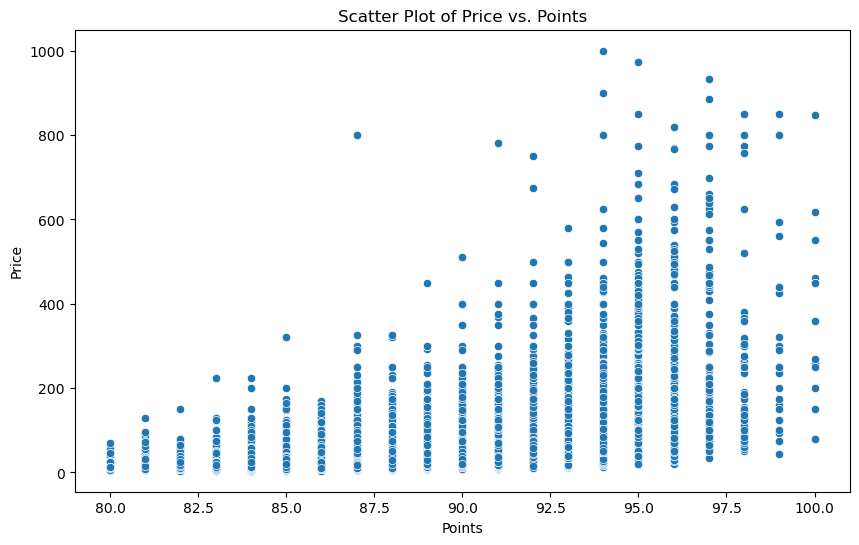

In [128]:
# Plot the scatterplot 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='points', y='price')
plt.title('Scatter Plot of Price vs. Points')
plt.xlabel('Points')
plt.ylabel('Price')
plt.show()

### 

In [129]:
# Calculate the Pearson correlation coefficient and p-value between 'price' and 'points'
correlation, p_value = stats.pearsonr(df['price'], df['points'])

# Print the Pearson correlation coefficient and p-value
print(f"Pearson correlation coefficient: {correlation}, p-value: {p_value}")

# Interpretation of the correlation results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between the price and rating of wine.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between the price and rating of wine.")

Pearson correlation coefficient: 0.47190271046544907, p-value: 0.0
Reject the null hypothesis: There is a significant correlation between the price and rating of wine.


### 

In [130]:
# Define a function to calculate the confidence interval for the Pearson correlation coefficient
def pearson_confidence_interval(r, n, alpha=0.05):
    r_z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    ci_low = r_z - z * se
    ci_high = r_z + z * se
    return np.tanh(ci_low), np.tanh(ci_high)

# Calculate the sample size
n = len(df['price'])

# Calculate the 95% confidence interval for the Pearson correlation coefficient
ci_low, ci_high = pearson_confidence_interval(correlation, n)

# Print the 95% confidence interval
print(f"95% confidence interval for the Pearson correlation coefficient: ({ci_low}, {ci_high})")

95% confidence interval for the Pearson correlation coefficient: (0.46706934919272086, 0.47670787189686187)


### Power Test for the hyptesis 3

In [131]:
from statsmodels.stats.power import NormalIndPower
correlation, p_value = stats.pearsonr(df['price'], df['points'])

# Perform power analysis
effect_size = correlation  # Use the observed correlation coefficient
alpha = 0.05  # Significance level
power = 0.8  # Desired power level
alternative = 'two-sided'  # Alternative hypothesis is two-sided

# Calculate the required sample size
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative=alternative)

print(f"Required sample size for 80% power: {sample_size:.2f}")

Required sample size for 80% power: 70.49


Based on the observed correlation coefficient, a sample size of approximately 70 is required to achieve 80% power for detecting the correlation at a significance level of 0.05. This indicates that with at least 70 data points, you can confidently detect a significant correlation between the price and rating of wines, assuming the observed effect size is accurate.

---

# Confidence Intervals

## Sample size by country

Let's have a look at the sample size for each of the variables we are going to analyse.

In [132]:
# Calculate the number of rows for each country
country_sample_sizes = df.groupby('country').size().reset_index(name='Sample Size')

# Calculate the number of points rows for each country
points_sample_sizes = df.groupby('country')['points'].count().reset_index(name='Points Sample Size')

# Calculate the number of price rows for each country
price_sample_sizes = df.groupby('country')['price'].count().reset_index(name='Price Sample Size')

# Merge the tables
result = country_sample_sizes.merge(points_sample_sizes, on='country').merge(price_sample_sizes, on='country')

#Exclude countries with zero samples in points and price
result = result[(result['Points Sample Size'] > 0) & (result['Price Sample Size'] > 0)]

# Sort in descending order by the number of samples
result = result.sort_values(by='Sample Size', ascending=False)

print(result)

           country  Sample Size  Points Sample Size  Price Sample Size
37              US        48001               48001              48001
12          France        15208               15208              15208
19           Italy        12324               12324              12324
34           Spain         4581                4581               4581
7            Chile         3944                3944               3944
28        Portugal         3461                3461               3461
0        Argentina         3095                3095               3095
2        Australia         1910                1910               1910
3          Austria         1872                1872               1872
14         Germany         1777                1777               1777
26     New Zealand         1227                1227               1227
33    South Africa         1030                1030               1030
18          Israel          411                 411                411
15    

there are several countries with a sample size < 30, we discard them because otherwise the confidence intervals are not accurate enough

In [133]:
# Exclude countries  with less than 30 samples
excluded_countries = result[(result['Sample Size'] < 30)]
result = result[(result['Sample Size'] >= 30)]

print("Included Countries:")
print(result)
print("\nExcluded Countries:")
print(excluded_countries)

Included Countries:
         country  Sample Size  Points Sample Size  Price Sample Size
37            US        48001               48001              48001
12        France        15208               15208              15208
19         Italy        12324               12324              12324
34         Spain         4581                4581               4581
7          Chile         3944                3944               3944
28      Portugal         3461                3461               3461
0      Argentina         3095                3095               3095
2      Australia         1910                1910               1910
3        Austria         1872                1872               1872
14       Germany         1777                1777               1777
26   New Zealand         1227                1227               1227
33  South Africa         1030                1030               1030
18        Israel          411                 411                411
15        Gree

We create a new dataset without those countries:

In [134]:
# Filter out countries with fewer than 30 points
country_counts = df['country'].value_counts()
valid_countries = country_counts[country_counts >= 30].index
excluded_countries = country_counts[country_counts < 30].index
df_filtered = df[df['country'].isin(valid_countries)]

## Wine Ratings Confidence Intervals By Country

95% Confidence Interval for the Mean Points of Wines: (88.43724009060718, 88.47596715414359)


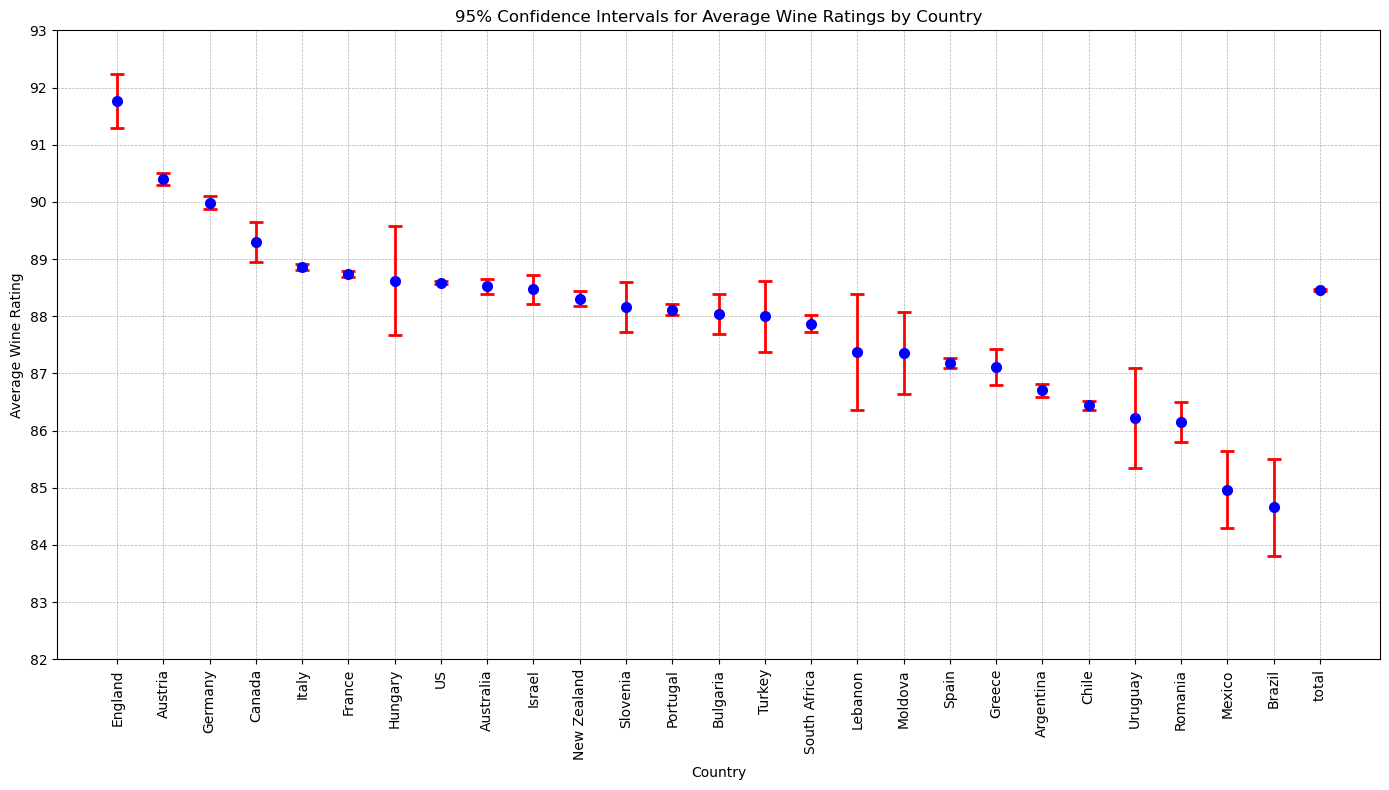

,Country,Mean,Lower CI,Upper CI
18,England,91.762712,91.292833,92.232591
9,Austria,90.399038,90.287619,90.510458
3,Germany,89.984243,89.869420,90.099066
21,Canada,89.305263,88.954780,89.655746
6,Italy,88.860273,88.811587,88.908958
2,France,88.738690,88.689661,88.787720
16,Hungary,88.619048,87.667471,89.570624
1,US,88.583696,88.555267,88.612126
8,Australia,88.521466,88.386716,88.656216
12,Israel,88.469586,88.221751,88.717422


In [135]:
# Calculate mean and standard error for the entire dataset
mean_points = df_filtered['points'].mean()
sem_points = stats.sem(df_filtered['points'].dropna())

# Calculate the confidence interval for the entire dataset
confidence_interval = stats.t.interval(0.95, len(df_filtered['points'])-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval}')

# Calculate mean and confidence interval for each country with a minimum of 30 points
countries = df_filtered['country'].unique()
confidence_intervals = []

for country in countries:
    country_data = df[df['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_points = pd.DataFrame(confidence_intervals, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_points = confidence_df_points.sort_values(by='Mean', ascending=False)

# Add general confidence interval
general_row = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval[0], 'Upper CI': confidence_interval[1]}
confidence_df_points.loc[len(confidence_df_points)] = general_row

# Plotting the confidence intervals
plt.figure(figsize=(14, 8))
plt.errorbar(confidence_df_points['Country'], confidence_df_points['Mean'], 
             yerr=[confidence_df_points['Mean'] - confidence_df_points['Lower CI'], confidence_df_points['Upper CI'] - confidence_df_points['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average Wine Rating')
plt.title('95% Confidence Intervals for Average Wine Ratings by Country')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.yticks(np.arange(82, 94, 1))

plt.show()
confidence_df_points

## Wine Price Confidence Intervals By Country

95% Confidence Interval for the Mean Price of Wines: (35.90882138922612, 36.36570177153682)


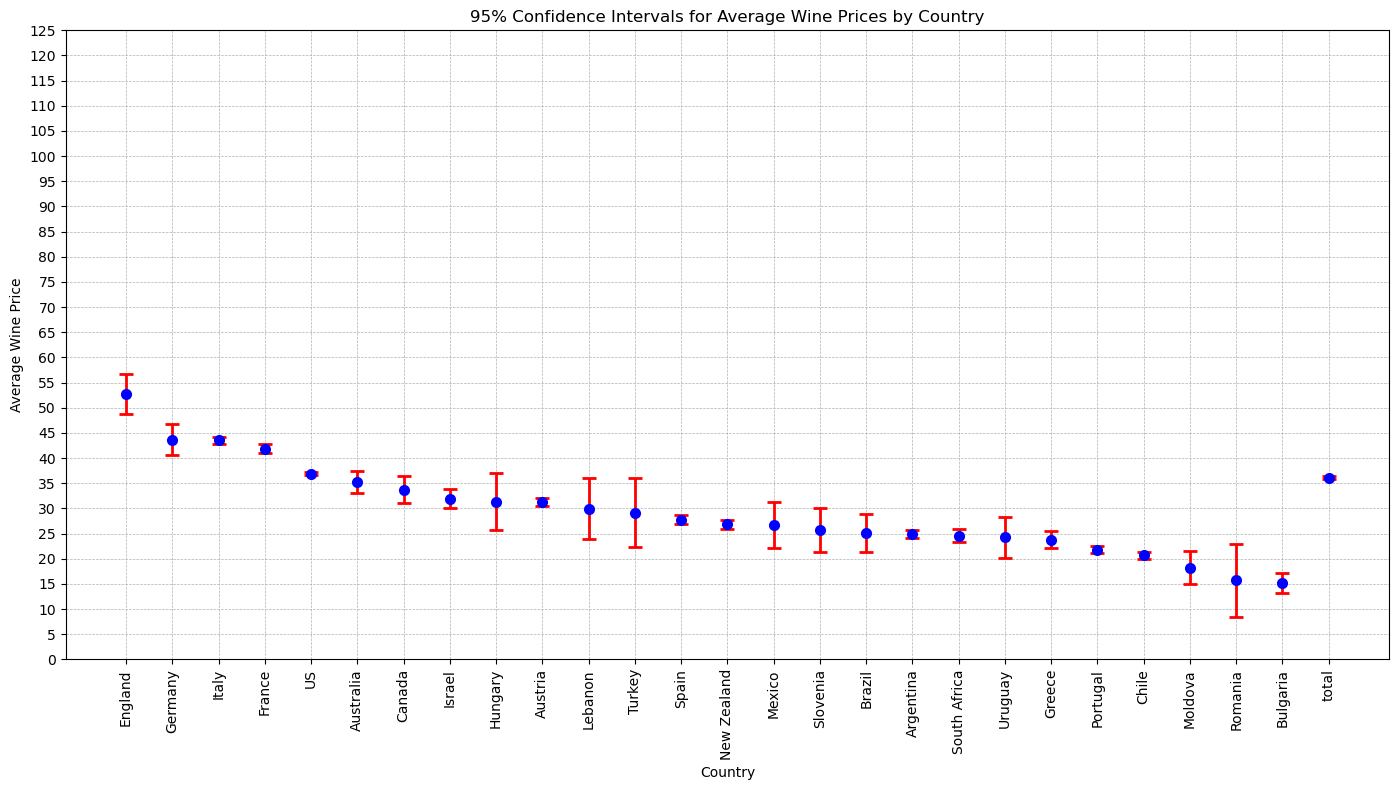

,Country,Mean,Lower CI,Upper CI
18,England,52.677966,48.745903,56.610029
3,Germany,43.631401,40.511071,46.751731
6,Italy,43.517851,42.781971,44.253732
2,France,41.882167,40.957422,42.806912
1,US,36.916398,36.680453,37.152342
8,Australia,35.253927,33.003146,37.504708
21,Canada,33.657895,30.974193,36.341597
12,Israel,31.922141,30.063918,33.780364
16,Hungary,31.333333,25.684217,36.982450
9,Austria,31.208868,30.386908,32.030827


In [136]:
# Calculate mean and standard error
mean_price = df_filtered['price'].mean()
sem_price = stats.sem(df_filtered['price'].dropna())

# Calculate the confidence interval
confidence_interval_price = stats.t.interval(0.95, len(df_filtered['price'])-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country
countries = df_filtered['country'].unique()
confidence_intervals_price = []

for country in countries:
    country_data = df_filtered[df_filtered['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_price = confidence_df_price.sort_values(by='Mean', ascending=False)

# Add general confidence interval
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price


# Plotting the confidence intervals for 'price'
plt.figure(figsize=(14, 8))
plt.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average Wine Price')
plt.title('95% Confidence Intervals for Average Wine Prices by Country')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.yticks(np.arange(0, 130, 5))  # Adjust this range based on your 'price' data


plt.show()

confidence_df_price

## Price - Rating comparison with size(log)

Dataset size: 99824
95% Confidence Interval for the Mean Points of Wines: (88.43724009060718, 88.47596715414359)
95% Confidence Interval for the Mean Price of Wines: (35.90882138922612, 36.36570177153682)


C:\Users\nicol\AppData\Local\Temp\ipykernel_37576\2935971765.py:66: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\nicol\AppData\Local\Temp\ipykernel_37576\2935971765.py:76: UserWarning:

FixedFormatter should only be used together with FixedLocator



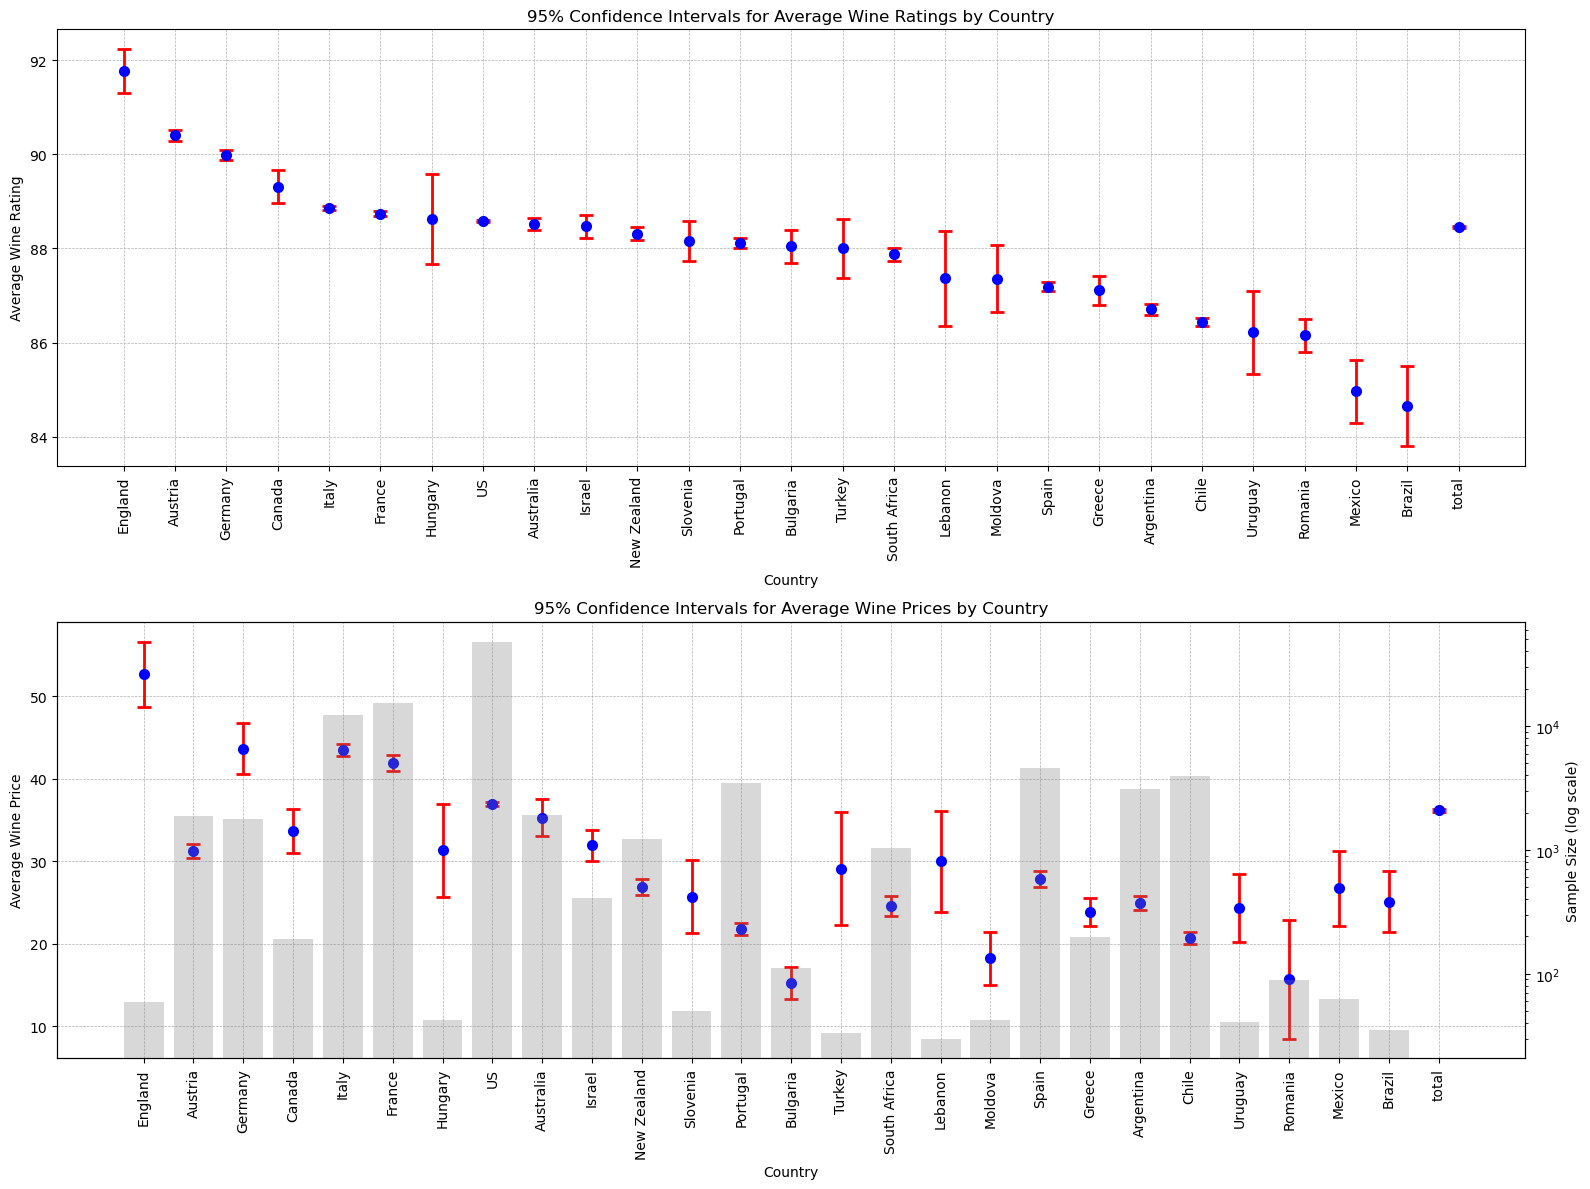

In [137]:
print(f"Dataset size: {len(df_filtered)}")

# Calculate mean and standard error for the entire dataset for 'points'
mean_points = df_filtered['points'].mean()
sem_points = stats.sem(df_filtered['points'].dropna())

# Calculate the confidence interval for the entire dataset for 'points'
confidence_interval_points = stats.t.interval(0.95, len(df_filtered['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval_points}')

# Calculate mean and confidence interval for each country for 'points'
countries = df_filtered['country'].unique()
confidence_intervals_points = []

for country in countries:
    country_data = df_filtered[df_filtered['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_points.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_points = pd.DataFrame(confidence_intervals_points, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_points = confidence_df_points.sort_values(by='Mean', ascending=False)

# Append the total statistics to the country data for 'points'
general_row_points = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval_points[0], 'Upper CI': confidence_interval_points[1]}
confidence_df_points.loc[len(confidence_df_points)] = general_row_points

# Calculate mean and standard error for the entire dataset for 'price'
mean_price = df_filtered['price'].mean()
sem_price = stats.sem(df_filtered['price'].dropna())

# Calculate the confidence interval for the entire dataset for 'price'
confidence_interval_price = stats.t.interval(0.95, len(df_filtered['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country for 'price'
confidence_intervals_price = []

for country in countries:
    country_data = df_filtered[df_filtered['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])

# Align the order of countries in 'confidence_df_price' to match 'confidence_df_points'
confidence_df_price = confidence_df_price.set_index('Country').reindex(confidence_df_points['Country']).reset_index()

# Append the total statistics to the country data for 'price'
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price

# Calculate the sample size for each country
sample_sizes = df['country'].value_counts().reindex(confidence_df_price['Country']).fillna(0)

# Plotting the confidence intervals for both wine ratings and prices side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot for wine ratings
ax1.errorbar(confidence_df_points['Country'], confidence_df_points['Mean'], 
             yerr=[confidence_df_points['Mean'] - confidence_df_points['Lower CI'], confidence_df_points['Upper CI'] - confidence_df_points['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Wine Rating')
ax1.set_title('95% Confidence Intervals for Average Wine Ratings by Country')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Plot for wine prices with histogram for sample sizes
ax2.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)
ax2.set_xlabel('Country')
ax2.set_ylabel('Average Wine Price')
ax2.set_title('95% Confidence Intervals for Average Wine Prices by Country')
ax2.grid(True, linestyle='--', linewidth=0.5)

# Secondary y-axis for sample sizes histogram with log scale
ax3 = ax2.twinx()
ax3.bar(confidence_df_price['Country'], sample_sizes, alpha=0.3, color='grey')
ax3.set_ylabel('Sample Size (log scale)')
ax3.set_yscale('log')

plt.tight_layout()
plt.show()

The trend in ratings is not perfectly followed by prices, although we do find correlations with an above-average price, especially for high ratings.

England is the top country in both charts, but it is difficult to say that it is the country with the best (and most expensive) wine, as it is one of the countries with the fewest samples.

## Lenght of Description Confidence Interval (full calculation)

In [138]:
# Step 1: Calculate Descriptive Statistics
sample_mean = df['review_length'].mean()
sample_std = df['review_length'].std()
sample_size = df['review_length'].count()

# Step 2: Choose a Confidence Level
confidence_level = 0.95

# Step 3: Find the Critical Value
degrees_of_freedom = sample_size - 1
t_critical = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

# Step 4: Calculate the Margin of Error (ME)
margin_of_error = t_critical * (sample_std / np.sqrt(sample_size))

# Step 5: Construct the Confidence Interval
confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)

# Display the results
print(f"sample_mean: {sample_mean}")
print(f"sample_std: {sample_std}")
print(f"sample_size: {sample_size}")
print(f"margin_of_error: {margin_of_error}")
print(f"confidence_interval: {confidence_interval}")

sample_mean: 244.7081690648202
sample_std: 67.72645130964845
sample_size: 99938
margin_of_error: 0.41990045404956916
confidence_interval: (244.28826861077061, 245.12806951886978)


---

# Linear Regression and correlation analysis

## Scatterplots and Correlation

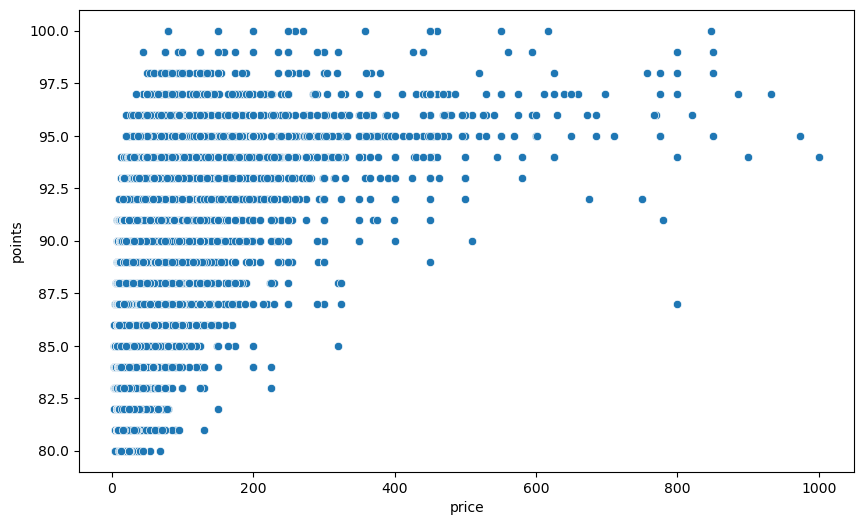

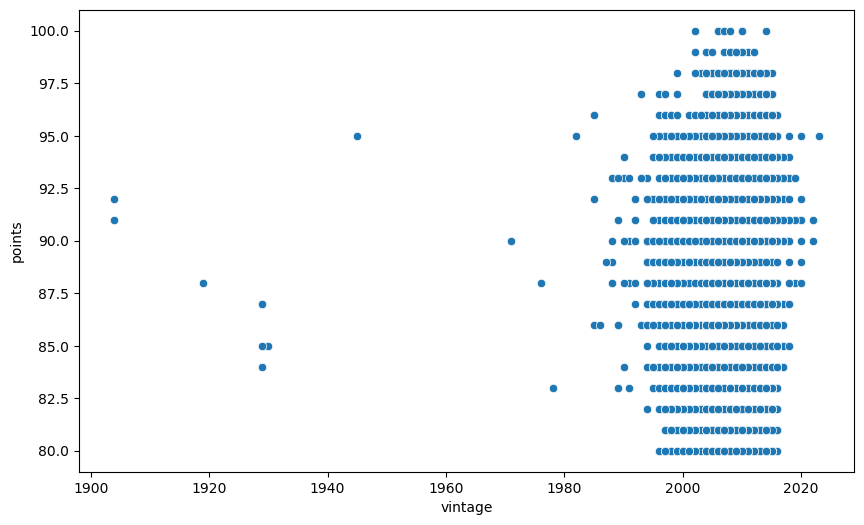

In [139]:
for i in ['price', 'vintage']:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=i, y="points")
    plt.show()

Scatter Plot 1: Points vs Price
Trend: There is a general positive trend where higher-priced wines tend to have higher points. However, this trend is not very strong, as there is significant spread at various price points.

Scatter Plot 2: Points vs Vintage
Trend: There is an observable pattern where older vintages (before 1980) tend to have lower points. Wines from more recent vintages (after 1980) generally have higher points.

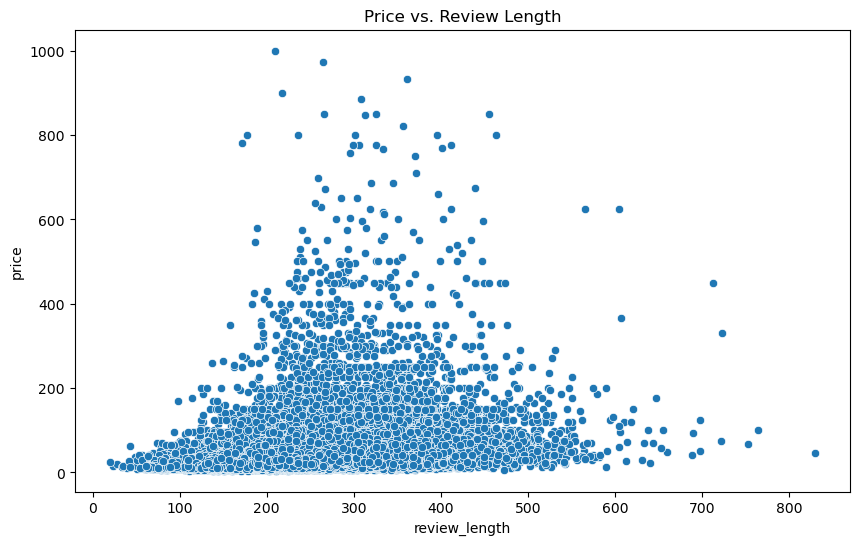

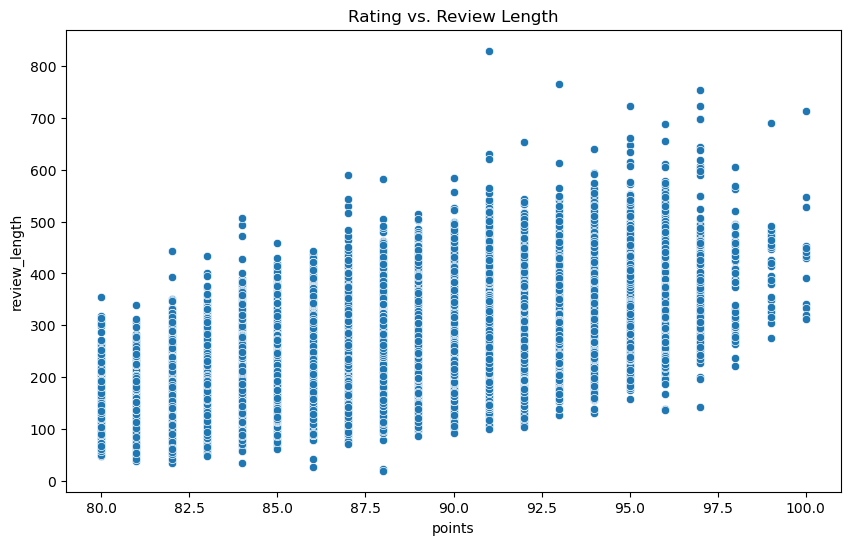

In [140]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_length', y='price', data=df)
plt.title('Price vs. Review Length')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='points', y='review_length', data=df)
plt.title('Rating vs. Review Length')
plt.show()

Scatter Plot 1: Price vs Review Length
Trend: There is no clear linear relationship between price and review_length. However, there is a noticeable spread that suggests higher prices tend to correspond with slightly longer reviews, although the variability is high.

Scatter Plot 2: Points vs Review Length
Trend: There is a positive correlation between points and review_length. As the length of the review increases, the points awarded tend to increase as well.

To ensure a robust and meaningful analysis, we decided to focus on the top 5 countries and the top 5 wine varieties. These selections were made based on their significant representation in the dataset, which means they have the highest number of wines recorded. . By concentrating on the most frequently occurring countries and varieties, we can ensure that our box plots and other analytical methods are well-supported by a sufficient volume of data, providing more accurate and representative insights into wine ratings and characteristics.

<Figure size 1000x600 with 0 Axes>

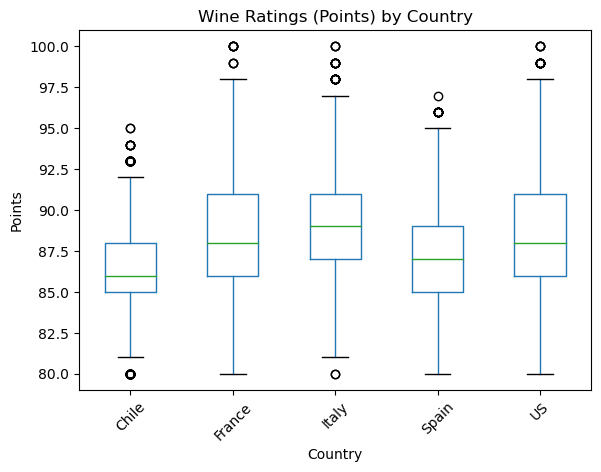

In [141]:
# Select top 5 countries by the number of wine reviews
top_countries = df['country'].value_counts().head(5).index
top_countries_data = df[df['country'].isin(top_countries)]

# Box plot for points by country
plt.figure(figsize=(10, 6))
top_countries_data.boxplot(column='points', by='country', grid=False)
plt.title('Wine Ratings (Points) by Country')
plt.suptitle('')
plt.xlabel('Country')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

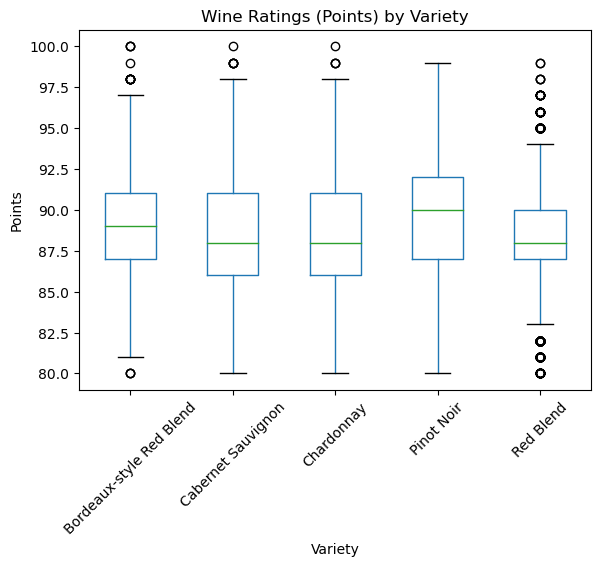

In [142]:
# Select top 5 varieties by the number of wine reviews
top_varieties = df['variety'].value_counts().head(5).index
top_varieties_data = df[df['variety'].isin(top_varieties)]

# Box plot for points by variety
plt.figure(figsize=(12, 8))
top_varieties_data.boxplot(column='points', by='variety', grid=False)
plt.title('Wine Ratings (Points) by Variety')
plt.suptitle('')
plt.xlabel('Variety')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()

In creating the correlation matrix we follow the same pirnciple, including only the top 5 countries and top 5 varieties


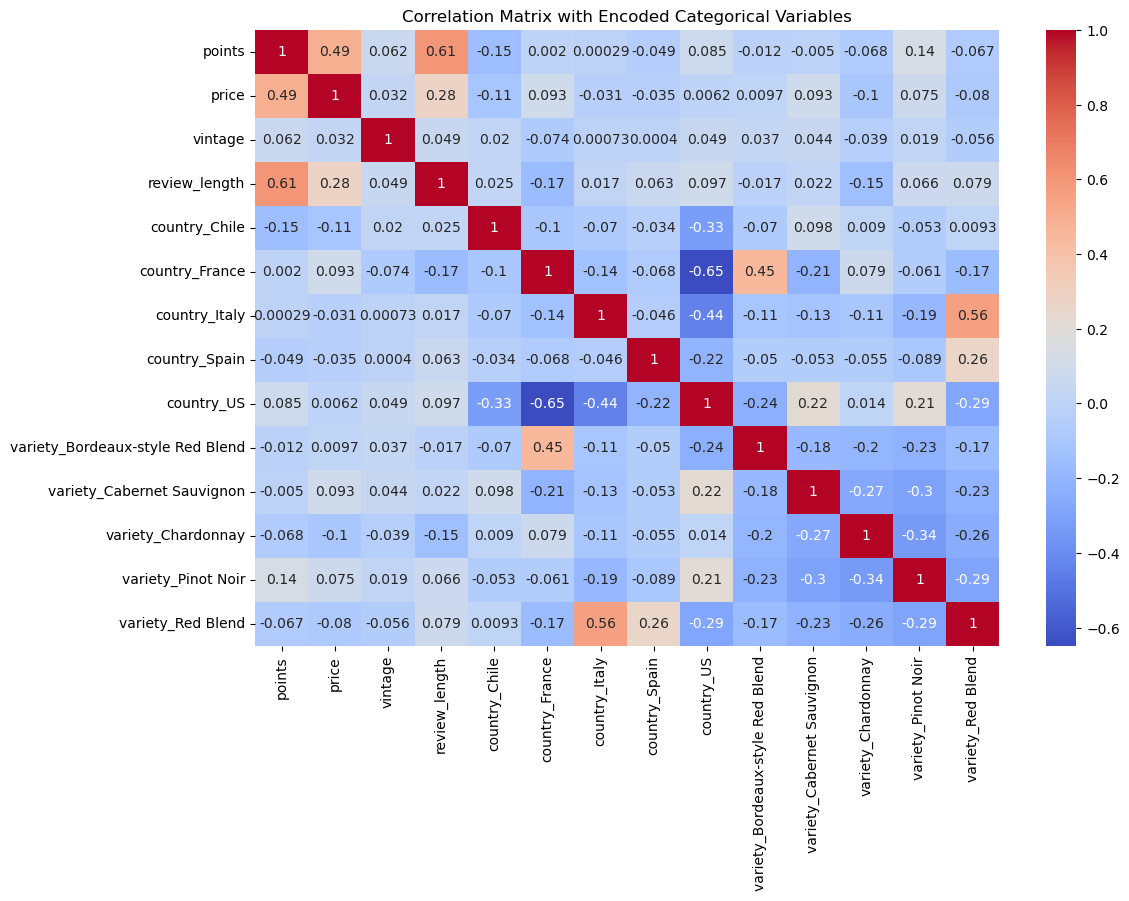

In [143]:
# Filtering the dataset to include only the top countries and top varieties
filtered_df = df[df['country'].isin(top_countries) & df['variety'].isin(top_varieties)]
columns_to_drop = ['description', 'designation', 'region_1', 'province', 'region_2', 'title', 'winery', 'price_category', 'is_outlier', 'wine_type']
filtered_df = filtered_df.drop(columns=columns_to_drop)

numerical_columns = ['price', 'points']
categorical_columns = ['country', 'variety']


# Dropping columns that are not needed for the analysis
encoded_df = pd.get_dummies(filtered_df, columns=categorical_columns)

# Ensuring that all columns are numerical
encoded_df = encoded_df.fillna(0)
encoded_df = encoded_df.astype(int)


# Calculate the correlation matrix for the encoded dataframe
encoded_correlation_matrix = encoded_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(encoded_correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Encoded Categorical Variables')
plt.show()

## Linear Regression 


predict the points using the review length

$\text{points} = b_0 + b_1 \cdot \text{review length}$


In [144]:
y = df['points']
x1 = df['review_length']

# Calculation of statistics needed
my = y.mean()
sy = y.std()
n = len(y)
mx1 = x1.mean()
sx1 = x1.std()

# Calculation of correlation coefficient
num1 = ((x1 - mx1) * (y - my)).sum() / (n - 1)
den1 = sx1 * sy
R_variety = num1 / den1

print("Linear correlation coefficient between points and review length = ", R_variety)

Linear correlation coefficient between points and review length =  0.5870808552593478


In [145]:
x_name = 'review_length'
x = df[x_name].copy()
mx = x.mean()
sx = x.std()
R = encoded_correlation_matrix.loc[x_name, 'points']
b1 = sy/sx*R
b0 = my-b1*mx
n = 42  
print(f"Points = {b0} + {b1} * Review length \nR^2 = {R**2}")

Points = 81.61465640701464 + 0.027951847845181385 * Review length 
R^2 = 0.3678073004389196


In [146]:
x = df[[x_name]].copy() # in statsmodel the intercept is modeled by adding a constant explanatory variable
x['intercept'] = 1
mod = sm.OLS(y, x) #OLS stands for ordinary least squares

fitted_mod = mod.fit()
print(fitted_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                 5.256e+04
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:37:22   Log-Likelihood:            -2.3445e+05
No. Observations:               99938   AIC:                         4.689e+05
Df Residuals:                   99936   BIC:                         4.689e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
review_length     0.0271      0.000    229.259

Both the review_length and intercept are statistically significant, indicating that the length of the review has a significant impact on the wine rating.
The model explains 34.5% of the variability in wine ratings with the length of the review. 

The review length coefficient shows an average increase of 0.0271 points for each additional word in the review, implying that longer reviews tend to be associated with slightly higher wine ratings. The intercept of 81.8333 indicates a baseline rating when the review length is zero.

Looking at the p-value for each coefficient (P>|t|) and the confidence intervals ([0.025 0.975]), we can conclude with very high confidence that these coefficients are significantly different from zero. Both the review length coefficient and the intercept have p-values close to 0, and their confidence intervals do not include zero, reinforcing the significance of the relationship.

### Prediction

The goal is to predict the wine rating (points) for a given review length (review_length = 80) 

In [147]:
# using manuak calculation
x0 = 80
y80 = b0+b1*x0
print("out model", y80)

# using statsmodel
y80st = fitted_mod.predict([80,1])
print("statsmodel", y80st)

out model 83.85080423462915
statsmodel [83.99800183]


We need also the prediction of the confidence interval

In [148]:
n= len(df)
Sres = np.sqrt(fitted_mod.mse_resid)
mx = encoded_df.review_length.mean()
SSx = (encoded_df.review_length**2).sum()
SE = Sres*np.sqrt(1+1/n+(x0-mx)**2/SSx)
alpha = 0.05
e = SE*stats.t.ppf(1-alpha/2,n-2)
print("Prediction interval for the points when review length is 80 char: [",y80-e , ", ", y80+e,"]")

Prediction interval for the points when review length is 80 char: [ 78.89800475078592 ,  88.80360371847239 ]


To evaluate the model's performance, let's visualize the predictions and analyze the residuals.

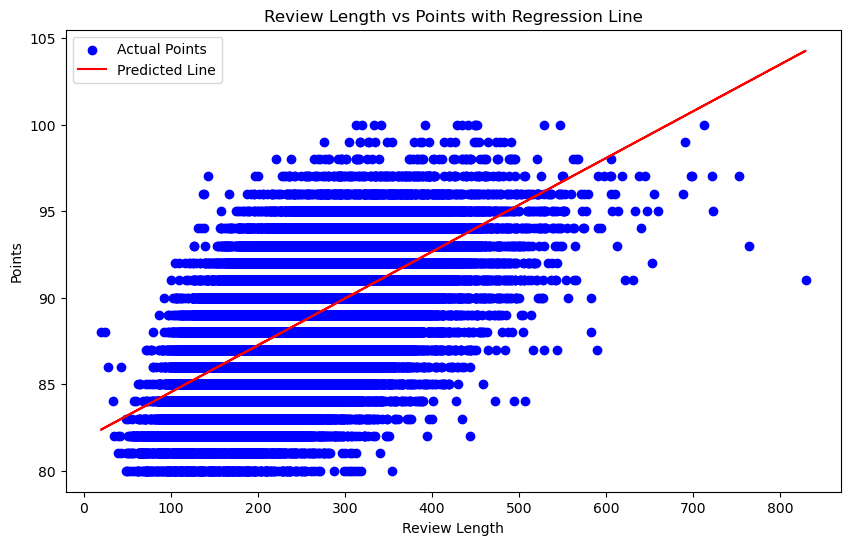

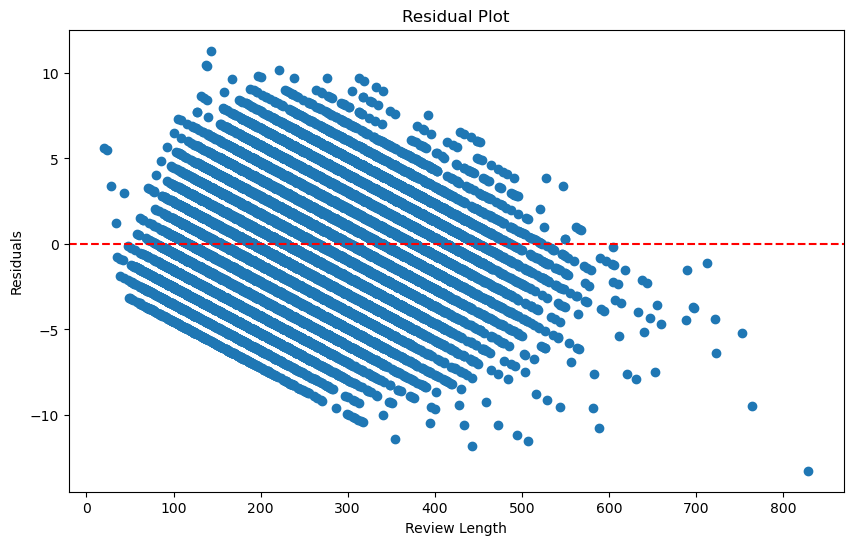

In [149]:
predictions = fitted_mod.predict(x)
plt.figure(figsize=(10, 6))
plt.scatter(x['review_length'], y, color='blue', label='Actual Points')
plt.plot(x['review_length'], predictions, color='red', label='Predicted Line')
plt.xlabel('Review Length')
plt.ylabel('Points')
plt.title('Review Length vs Points with Regression Line')
plt.legend()
plt.show()

# Residuals vs Fitted Values
residuals = y - predictions
plt.figure(figsize=(10, 6))
plt.scatter(x['review_length'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Review Length')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Multiple linear regression

We want to perform a multiple linear regression analysis using several independent variables to predict wine ratings (points)

In [150]:
y = encoded_df['points']

# Independent variables (x)
expl_var = [c for c in encoded_df.columns if c != 'points']
x = encoded_df[expl_var].copy()  
x['intercept'] = 1  

# Align the indices of y and x
y = y.loc[x.index]

#perform linear regression
mod = sm.OLS(y, x)
fitted_mod = mod.fit()

print(fitted_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     3825.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:37:24   Log-Likelihood:                -88009.
No. Observations:               39547   AIC:                         1.760e+05
Df Residuals:                   39535   BIC:                         1.761e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
price   

The regression results indicate that the model explains about 51.6% of the variability in wine ratings, with all predictors being statistically significant. This suggests that the included predictors are meaningful contributors to explaining the differences in wine ratings.

for this reason, we now evaluate the individual explanatory power of each independent variable in the dataset relative to the dependent variable (points) and then evaluate the incremental explanatory power of adding each remaining variable. This is a stepwise regression process, in which we start with one predictor and iteratively add other predictors to see how much they improve the model in the following steps:

In [151]:
# step 1

for v in expl_var:
    
    x = encoded_df[[v]].copy()
    x['intercept'] = 1
    mod = sm.OLS(y, x) #OLS stands for ordinary least squares

    fitted_mod = mod.fit()
    print("Adjusted R2 using ", v, ": ", fitted_mod.rsquared_adj)

Adjusted R2 using  price :  0.24152875054589795
Adjusted R2 using  vintage :  0.003857138108460778
Adjusted R2 using  review_length :  0.3677913137731148
Adjusted R2 using  country_Chile :  0.023882799057628912
Adjusted R2 using  country_France :  -2.1253736762538722e-05
Adjusted R2 using  country_Italy :  -2.520378529258238e-05
Adjusted R2 using  country_Spain :  0.0023658131631622004
Adjusted R2 using  country_US :  0.007145536593909485
Adjusted R2 using  variety_Bordeaux-style Red Blend :  0.00011490210914344434
Adjusted R2 using  variety_Cabernet Sauvignon :  1.5007349207785126e-07
Adjusted R2 using  variety_Chardonnay :  0.004657716937771728
Adjusted R2 using  variety_Pinot Noir :  0.018249572690429483
Adjusted R2 using  variety_Red Blend :  0.004509277623430119


The maximum value of the adjusted R2 is obtained using variable price. 
Let's now try to add a further variable. 

In [152]:
# step 2

expl_var_chosen = ['price'] 
expl_var_left = [c  for c in expl_var if c!= 'price'] 

for v in expl_var_left:
    expl_var = expl_var_chosen+[v]

    x = encoded_df[expl_var].copy()
    x['intercept'] = 1
    mod = sm.OLS(y, x) #OLS stands for ordinary least squares

    fitted_mod = mod.fit()
    print("Adjusted R2 adding ", v, ": ", fitted_mod.rsquared_adj)

Adjusted R2 adding  vintage :  0.2436766072215817
Adjusted R2 adding  review_length :  0.47987665049838224
Adjusted R2 adding  country_Chile :  0.2516106270269808
Adjusted R2 adding  country_France :  0.24344015602191016
Adjusted R2 adding  country_Italy :  0.24174705428297794
Adjusted R2 adding  country_Spain :  0.2425002943301532
Adjusted R2 adding  country_US :  0.24817474641568305
Adjusted R2 adding  variety_Bordeaux-style Red Blend :  0.24178467556254746
Adjusted R2 adding  variety_Cabernet Sauvignon :  0.2441093530524634
Adjusted R2 adding  variety_Chardonnay :  0.24184235651392028
Adjusted R2 adding  variety_Pinot Noir :  0.2511933677911714
Adjusted R2 adding  variety_Red Blend :  0.2423065271806334


The adjusted R2 improves if we add the explanatory variable review_length.


In [153]:
# step 3

expl_var_chosen = expl_var_chosen+['review_length'] 
expl_var_left = [c  for c in expl_var_left if c!= 'review_length'] 

for v in expl_var_left:
    expl_var = expl_var_chosen+[v]

    x = encoded_df[expl_var].copy()
    x['intercept'] = 1
    mod = sm.OLS(y, x) #OLS stands for ordinary least squares

    fitted_mod = mod.fit()
    print("Adjusted R2 adding ", v, ": ", fitted_mod.rsquared_adj)

Adjusted R2 adding  vintage :  0.4805532945977745
Adjusted R2 adding  country_Chile :  0.4967025129509257
Adjusted R2 adding  country_France :  0.4833055558235976
Adjusted R2 adding  country_Italy :  0.4798698033393469
Adjusted R2 adding  country_Spain :  0.48457125769832265
Adjusted R2 adding  country_US :  0.4809892539290299
Adjusted R2 adding  variety_Bordeaux-style Red Blend :  0.47990582180403774
Adjusted R2 adding  variety_Cabernet Sauvignon :  0.482254332012247
Adjusted R2 adding  variety_Chardonnay :  0.48179576829558945
Adjusted R2 adding  variety_Pinot Noir :  0.4855532675826305
Adjusted R2 adding  variety_Red Blend :  0.4863008247928011


The adjusted R2 improves if we add the explanatory variable country_Chile

In [154]:
# step 4

expl_var_chosen = expl_var_chosen+['country_Chile'] 
expl_var_left = [c  for c in expl_var_left if c!= 'country_Chile'] 

for v in expl_var_left:
    expl_var = expl_var_chosen+[v]

    x = encoded_df[expl_var].copy()
    x['intercept'] = 1
    mod = sm.OLS(y, x) #OLS stands for ordinary least squares

    fitted_mod = mod.fit()
    print("Adjusted R2 adding ", v, ": ", fitted_mod.rsquared_adj)

Adjusted R2 adding  vintage :  0.49753283288238825
Adjusted R2 adding  country_France :  0.4989988028898249
Adjusted R2 adding  country_Italy :  0.4967429217636181
Adjusted R2 adding  country_Spain :  0.5022060974221738
Adjusted R2 adding  country_US :  0.4967998729217745
Adjusted R2 adding  variety_Bordeaux-style Red Blend :  0.49692558471170856
Adjusted R2 adding  variety_Cabernet Sauvignon :  0.497902147618675
Adjusted R2 adding  variety_Chardonnay :  0.49868151382010384
Adjusted R2 adding  variety_Pinot Noir :  0.5014893497364117
Adjusted R2 adding  variety_Red Blend :  0.5032518948123581


The adjusted R2 improves if we add the explanatory variable variety_Red Blend

In [155]:
# step 5

expl_var_chosen = expl_var_chosen+['variety_Red Blend'] 
expl_var_left = [c  for c in expl_var_left if c!= 'variety_Red Blend'] 

for v in expl_var_left:
    expl_var = expl_var_chosen+[v]

    x = encoded_df[expl_var].copy()
    x['intercept'] = 1
    mod = sm.OLS(y, x) #OLS stands for ordinary least squares

    fitted_mod = mod.fit()
    print("Adjusted R2 adding ", v, ": ", fitted_mod.rsquared_adj)

Adjusted R2 adding  vintage :  0.5038343767236364
Adjusted R2 adding  country_France :  0.5045792462720924
Adjusted R2 adding  country_Italy :  0.5053835024627239
Adjusted R2 adding  country_Spain :  0.5063210751271547
Adjusted R2 adding  country_US :  0.5047221314218113
Adjusted R2 adding  variety_Bordeaux-style Red Blend :  0.50411517897721
Adjusted R2 adding  variety_Cabernet Sauvignon :  0.506211623344918
Adjusted R2 adding  variety_Chardonnay :  0.5038480252491528
Adjusted R2 adding  variety_Pinot Noir :  0.5055119167185029


In all cases the adjusted R2 decreases, so there is no advantage in adding further variables. The optimal model is the one using the price, review_length, country_Chile and variety_Red Blend.

In [156]:
expl_var = ['price', 'review_length', 'country_Chile', 'variety_Red Blend'] 

x = encoded_df[expl_var].copy()
x['constant'] = 1
mod = sm.OLS(y, x) #OLS stands for ordinary least squares

fitted_mod = mod.fit()
print(fitted_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                 1.002e+04
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:37:25   Log-Likelihood:                -88502.
No. Observations:               39547   AIC:                         1.770e+05
Df Residuals:                   39542   BIC:                         1.771e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
price                 0.0251      0.00

the regression model indicates that price and review_length positively influence wine ratings, while being from Chile or being a Red Blend variety negatively influences ratings. This provides a comprehensive understanding of how these factors impact wine ratings.

The above result, describes the following linear regression model

$\text{points} = 81.9932 + 0.0251\cdot\text{price} + 0.0239\cdot\text{review length} - 1.9568\cdot\text{country Chile} - 0.6856\cdot\text{variety Red Blend}$


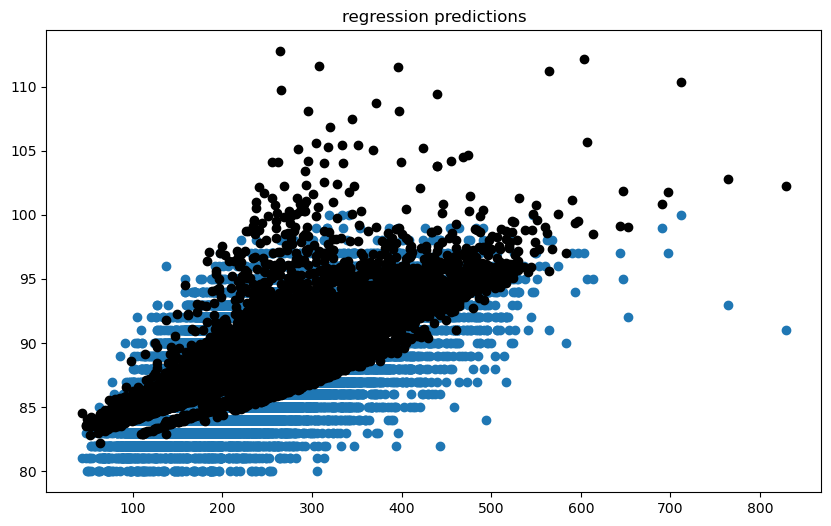

In [157]:
predictions = fitted_mod.predict(x)
plt.figure(figsize=(10, 6))
plt.scatter(x = x['review_length'],y = y)
plt.scatter(x['review_length'],predictions, c = 'black')
plt.title('regression predictions')
plt.show()


This graph shows the predicted wine ratings (black points) compared to the actual wine ratings (blue points) against the review length. The black points, which represent the model's predictions, generally align with the blue points, indicating that the model captures the overall trend. However, there is a noticeable spread, particularly at higher review lengths, suggesting that the model's accuracy decreases for longer reviews.

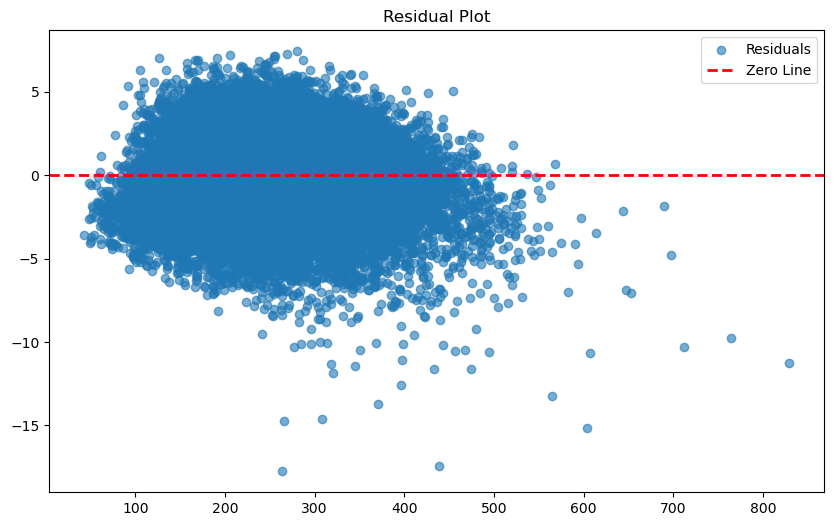

In [158]:
residuals = y - predictions

# Calculate residuals
plt.figure(figsize=(10, 6))
plt.scatter(x['review_length'], residuals, label='Residuals', alpha=0.6)
plt.axhline(0, color='r', linestyle='--', linewidth=2, label='Zero Line')
plt.title('Residual Plot')
plt.legend()
plt.show()

This graph illustrates the residuals, or differences between the observed and predicted wine ratings, against the review length. The residuals (blue points) are centered around the zero line (red dashed line), indicating that the model predictions are generally unbiased.

Finally, we plot the histogram of the residuals to check the normality assumption.

<Axes: >

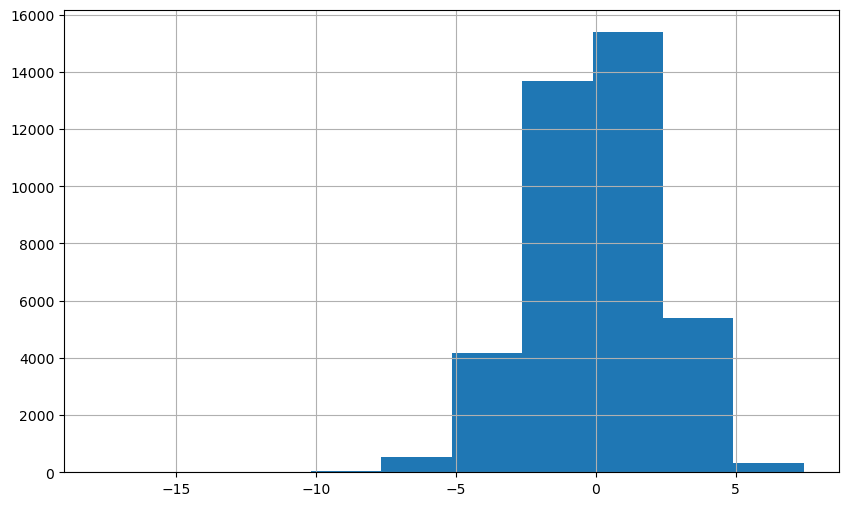

In [159]:
plt.figure(figsize=(10, 6))
residuals.hist()

While the distribution is approximately centered around zero and somewhat symmetric, it shows left skewness and a higher peak, which suggests that it does not follow a perfect normal distribution.

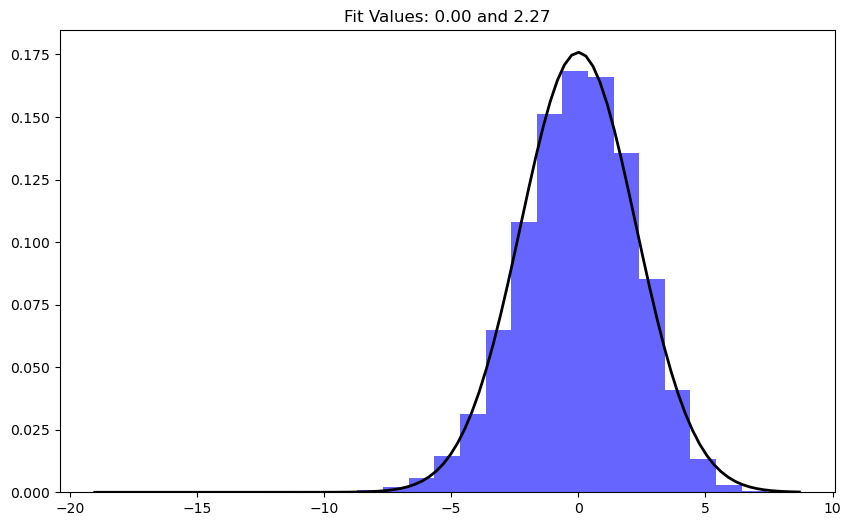

         mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0 -195.172132  5.324724     -205.60872    -184.735545   -206.516209   

   obs_ci_upper  
0   -183.828055  


In [160]:
# Fit a normal distribution to the residuals:
# mean and standard deviation
mu, std = stats.norm.fit(residuals)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF
xmin, xmax = plt.xlim()
x_range = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x_range, mu, std)

plt.plot(x_range, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.show()

# Making predictions with new data
# Aggiungi tutte le variabili utilizzate nel modello originale
new_data = pd.DataFrame({
    'price': [20],
    'review_length': [100],
    'country_Chile': [0],  # Aggiungi altre variabili con valori appropriati
    'variety_Red Blend': [0]
})
new_data['intercept'] = 1

# Assicurati che l'ordine delle colonne corrisponda a quello del modello
new_data = new_data[['intercept', 'price', 'review_length', 'country_Chile', 'variety_Red Blend']]

# Predict
predictions = fitted_mod.get_prediction(new_data)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% prediction interval
print(pred_summary)

The plot indicates that the residuals are roughly normally distributed, centered around zero. This suggests that the model's predictions are generally unbiased, although there are some deviations from normality, especially in the tails.

---

# Conclusions

In this analysis, we aimed to understand the factors influencing wine ratings using a multiple linear regression model. Several key steps were undertaken to achieve this goal:

**Data Preprocessing:**:
The dataset was cleaned and preprocessed to handle missing values, encode categorical variables, and ensure the data was suitable for regression analysis.

**Exploratory Data Analysis (EDA):**
Initial exploration of the data included summary statistics and visualizations. We examined the distribution of wine ratings (points), as well as the distributions and correlations of potential predictor variables, such as price, review length, and categorical variables representing country and variety.

**Correlation Analysis:**
A correlation matrix was generated to identify relationships between numerical variables. This helped in understanding which variables were most strongly associated with wine ratings and could be important predictors in our model.

**Regression Analysis:**
We performed multiple linear regression analysis using variables such as price, review length, and dummy variables for countries and wine varieties. The model was evaluated using metrics like R-squared and adjusted R-squared to assess the proportion of variance in wine ratings explained by the predictors. The significance of individual predictors was assessed using p-values and confidence intervals.

**Model Diagnostics:**
Residual plots and histograms of residuals were used to evaluate the assumptions of linear regression, such as homoscedasticity and normality of residuals. The residuals were found to be approximately normally distributed, but with some deviations, particularly in the tails, suggesting areas for potential model improvement.

**Predictions:**
The model was used to make predictions for new data points, providing both point estimates and prediction intervals. This demonstrated the practical applicability of the model for estimating wine ratings based on the predictors.

**Key Findings**
- Price and Review Length: Both price and review length were significant predictors of wine ratings. Higher prices and longer reviews were associated with higher ratings.
- Country and Variety Effects: Wines from different countries and of different varieties showed significant differences in ratings. For instance, wines from Chile and Red Blend varieties tended to receive lower ratings on average compared to other categories.
- Model Performance: The regression model explained approximately 50% of the variance in wine ratings, indicating a moderate level of explanatory power. However, there is room for improvement, potentially through the inclusion of additional variables or more complex modeling techniques.

**Recommendations**
- Data Collection: Future analyses could benefit from collecting additional data on factors such as vineyard practices, wine age, and expert reviews, which might further explain the variability in wine ratings.
- Model Refinement: Consider exploring more advanced modeling techniques, such as random forest regression or gradient boosting, to capture non-linear relationships and interactions between variables.
- Market Insights: The findings can be useful for wine producers and marketers to understand the attributes that are most valued by consumers and to tailor their products and marketing strategies accordingly.

>In summary, this analysis provides valuable insights into the factors influencing wine ratings and demonstrates the utility of regression modeling in predicting these ratings. The results highlight the importance of price, review length, and specific country and variety attributes in determining wine quality as perceived by consumers.